In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from IPython.display import display
import zipfile
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torchvision.models import densenet121 
from torchvision.models import densenet121, DenseNet121_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torchvision.models import mobilenet_v2
from torchvision.models import MobileNet_V2_Weights
from torch.optim.lr_scheduler import LambdaLR
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
import torch.nn.functional as F


1 пункт


In [ ]:
data="data (1).zip"

with zipfile.ZipFile(data, 'r') as zipf:
    zipf.extractall("dataset")

In [9]:
data="data (1).zip"
train_direct="dataset/train"
test_direct="dataset/test"

In [ ]:
with zipfile.ZipFile(data, 'r') as zipf:
    zipf.extractall("dataset")

In [10]:
train_dataset = ImageFolder(train_direct)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [12]:
#закомментировала так как очень много фото и файл тяжело листать становится 
# img_100 = {}

# for img, class_num in train_dataset:
#     if class_num not in img_100:
#         img_100[class_num] = img
#     if len(img_100) == len(train_dataset.classes):
#         break

# for class_num, img in img_100.items():
#     plt.imshow(img)
#     plt.title(train_dataset.classes[class_num])
#     plt.show()

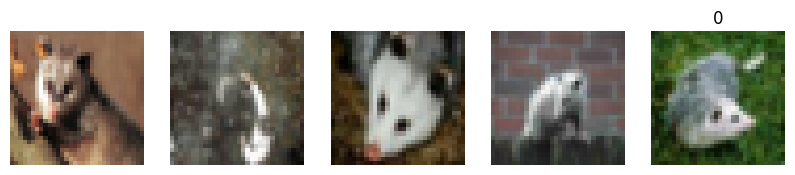

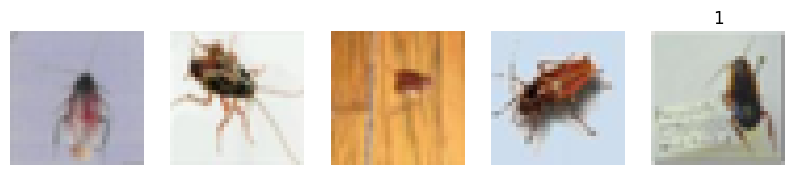

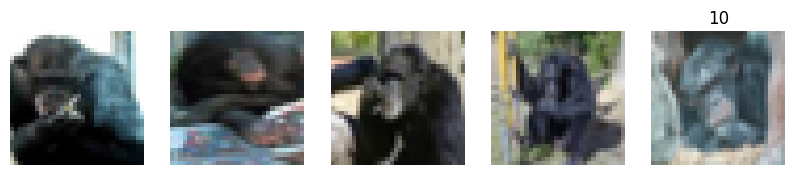

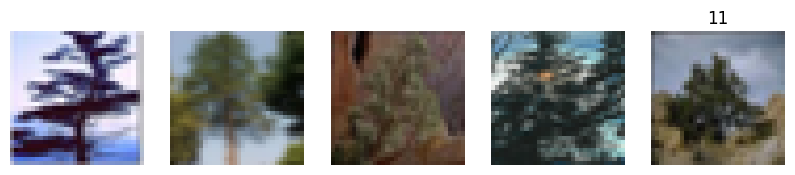

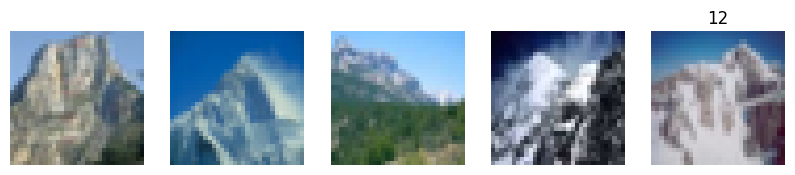

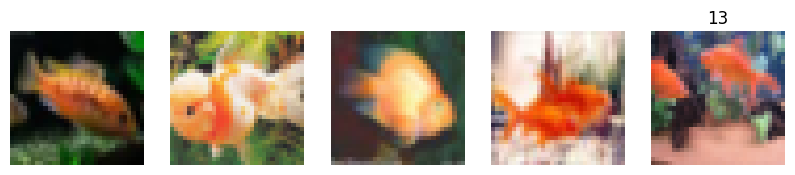

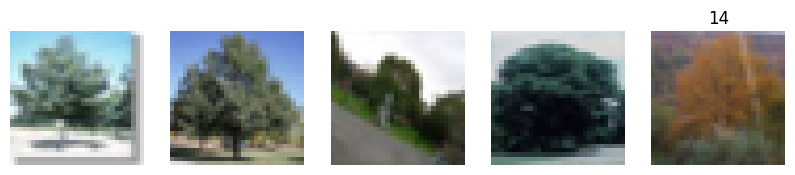

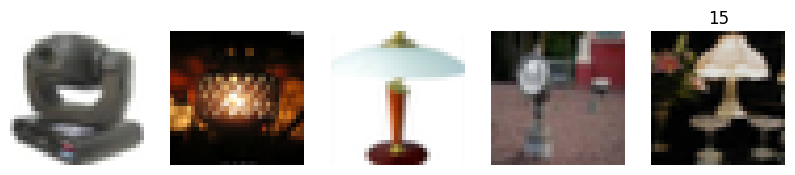

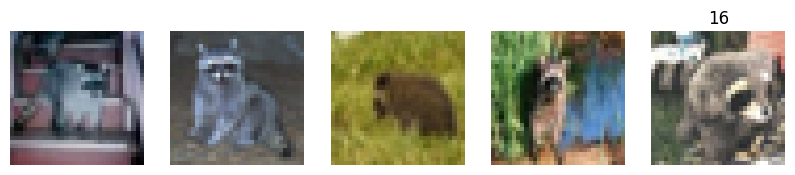

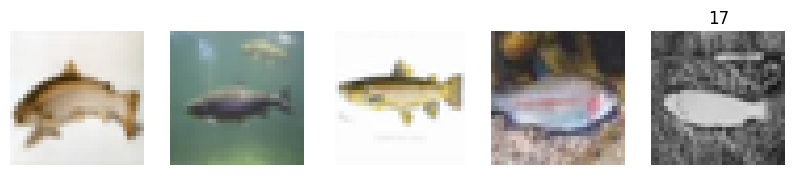

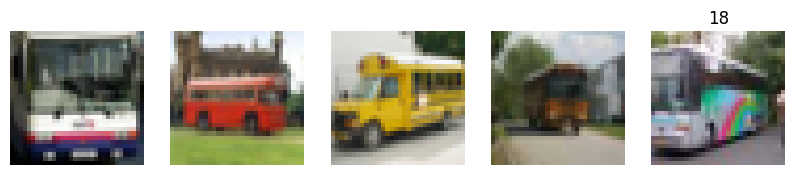

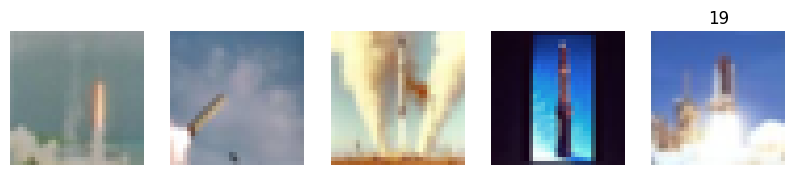

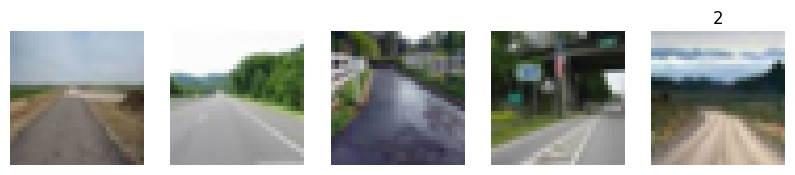

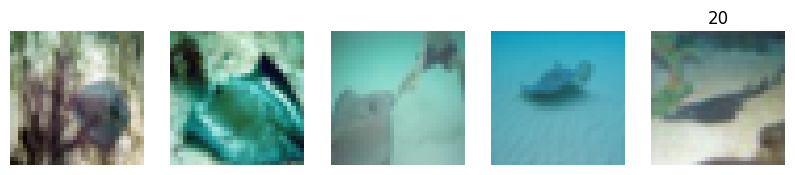

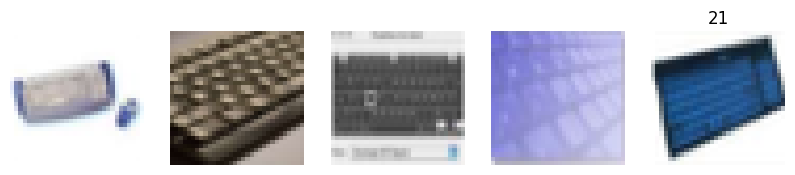

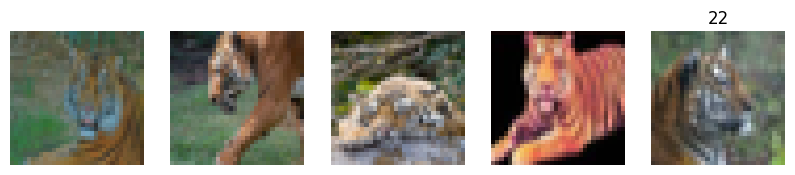

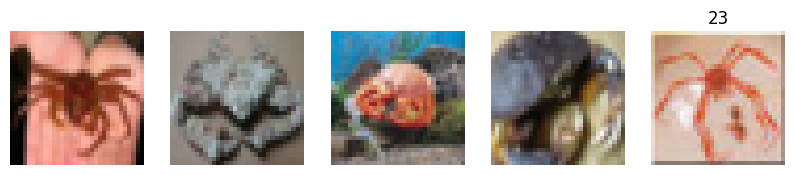

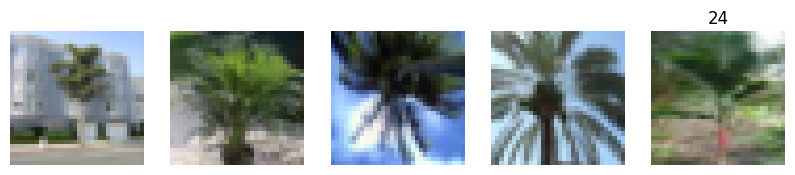

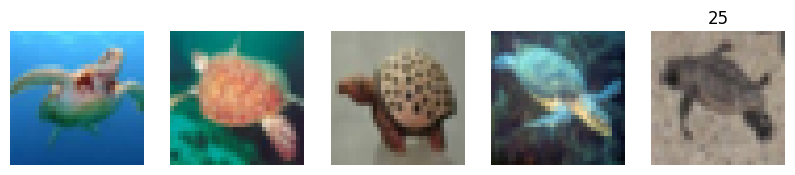

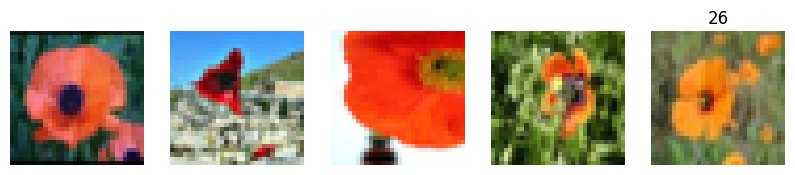

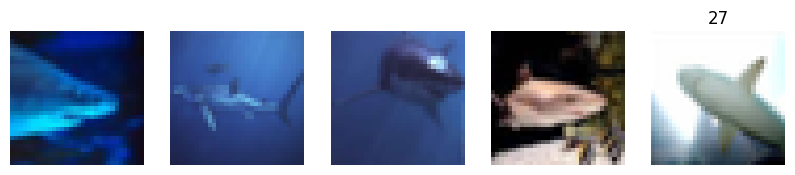

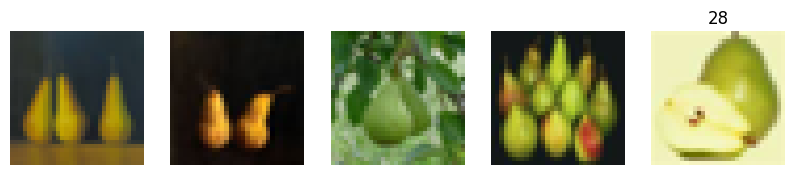

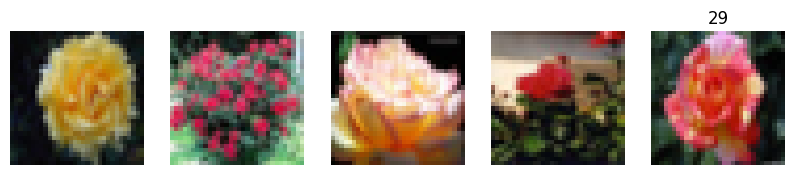

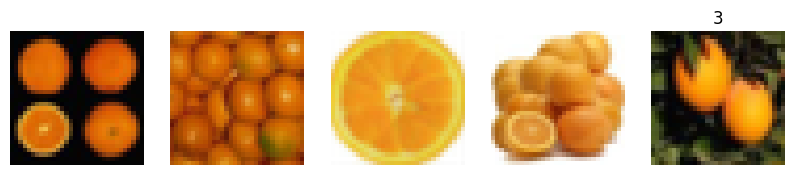

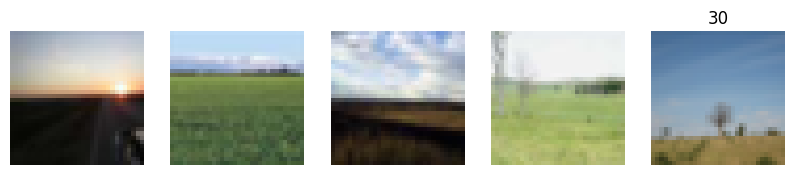

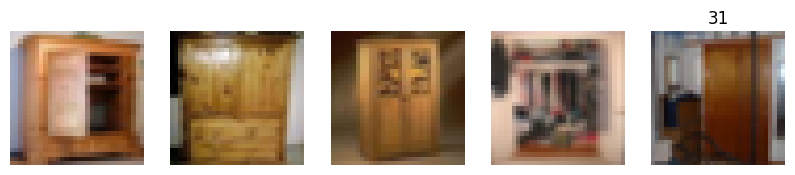

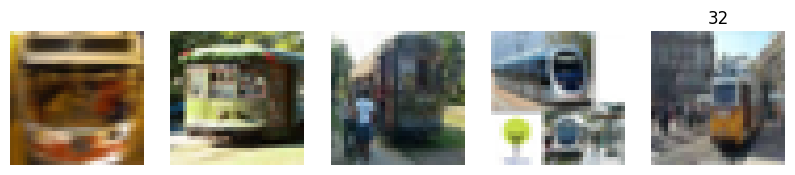

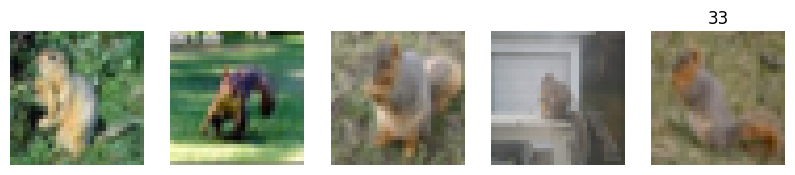

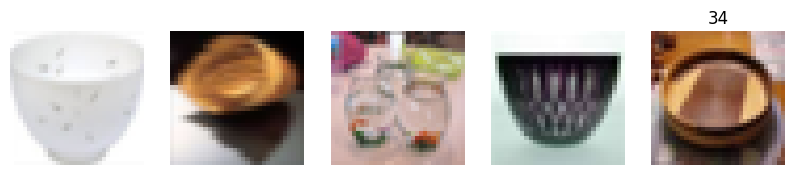

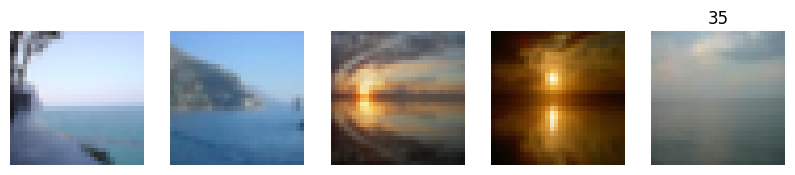

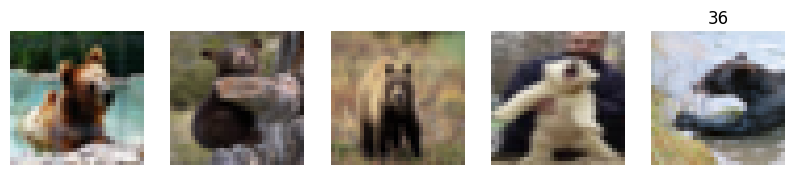

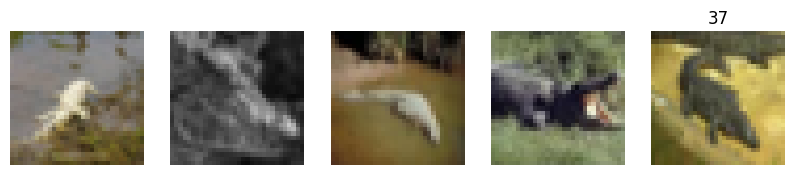

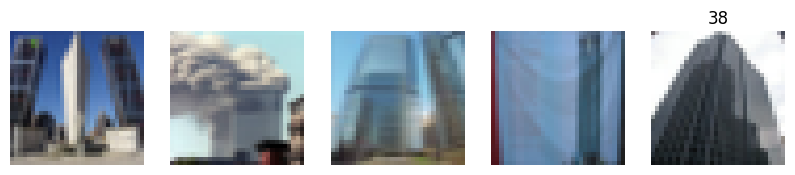

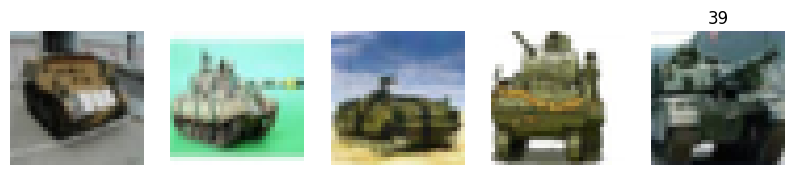

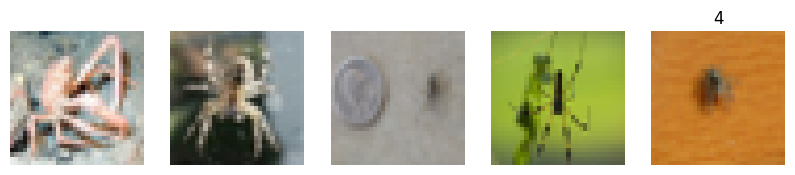

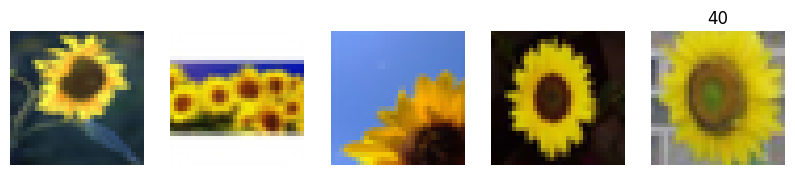

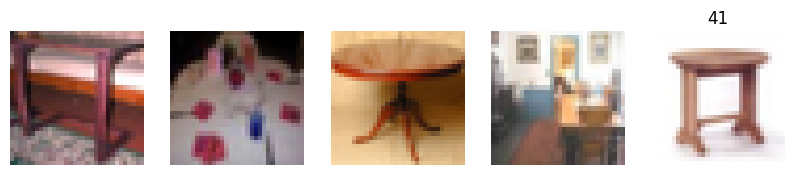

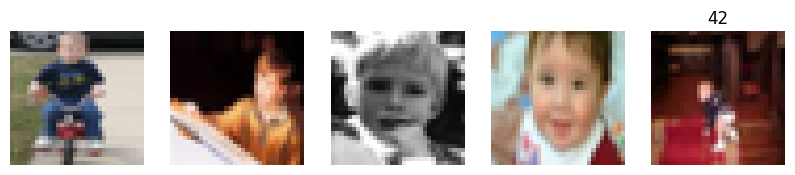

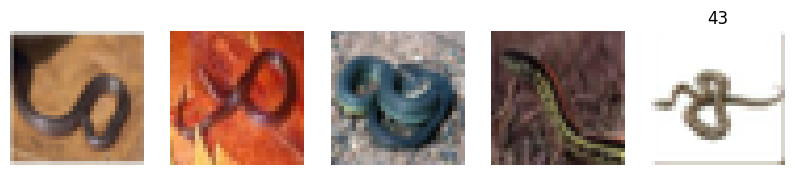

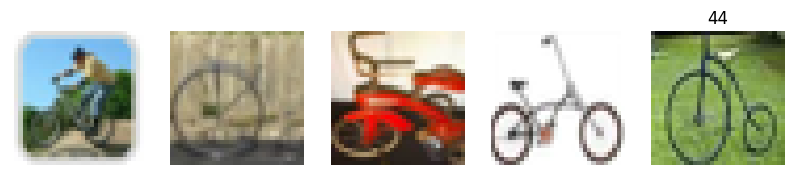

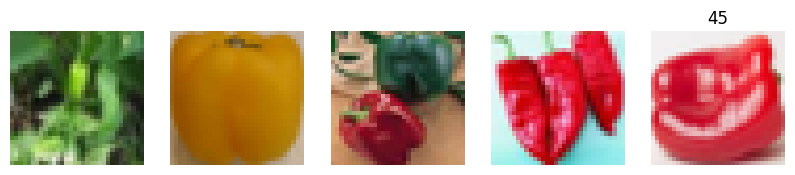

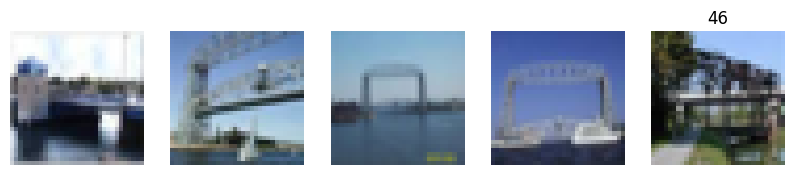

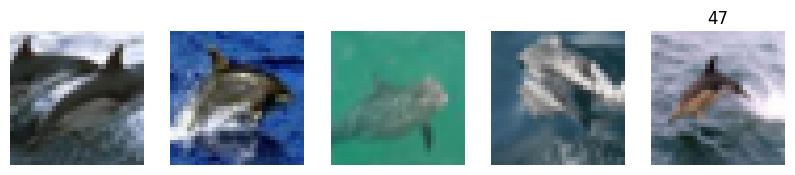

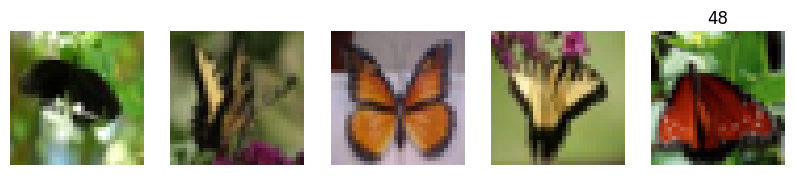

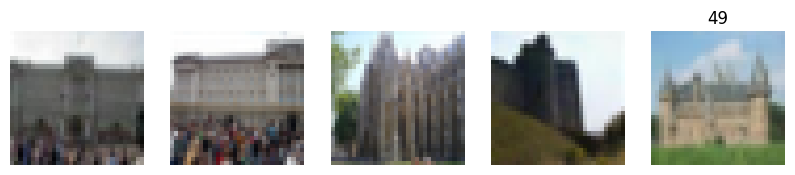

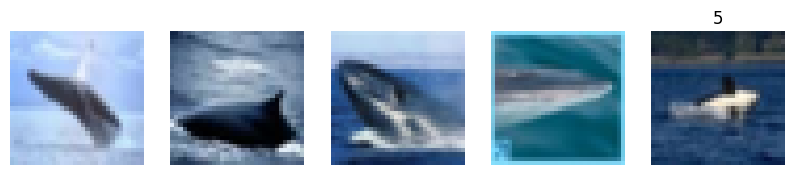

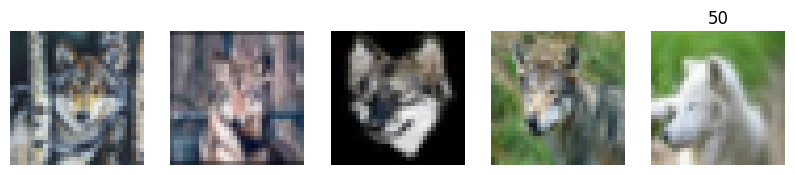

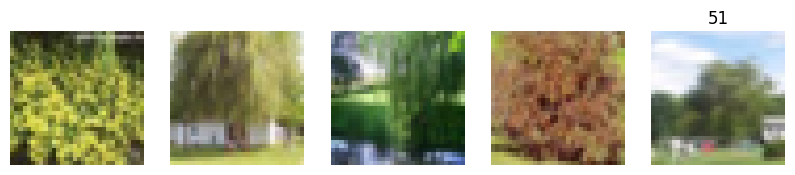

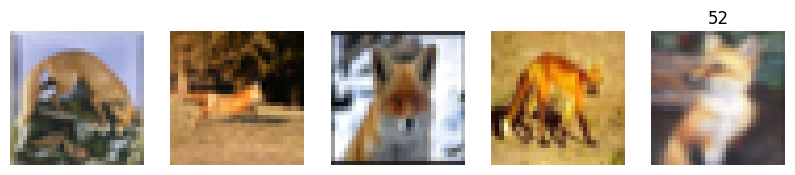

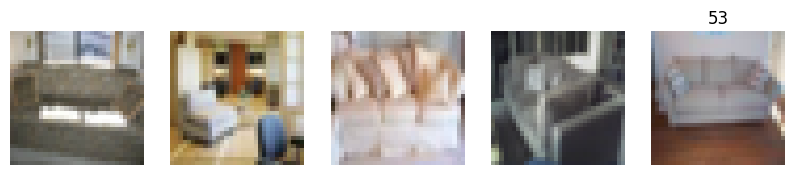

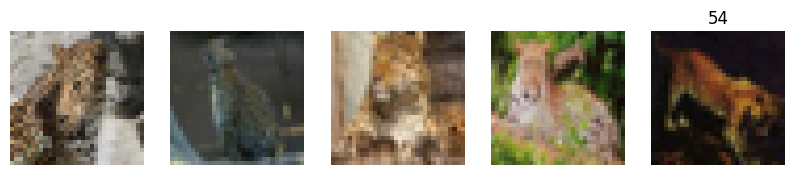

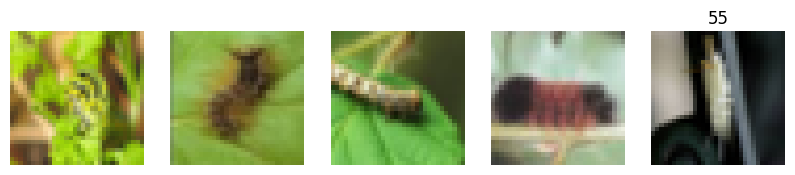

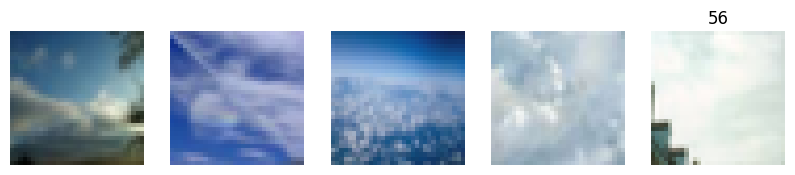

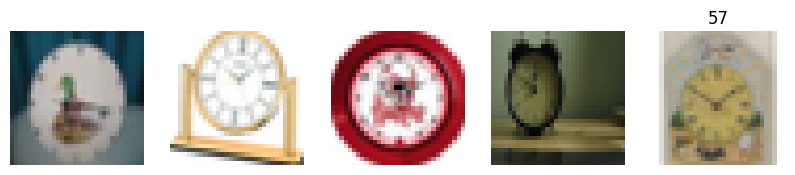

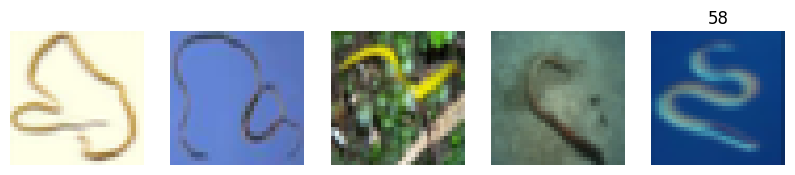

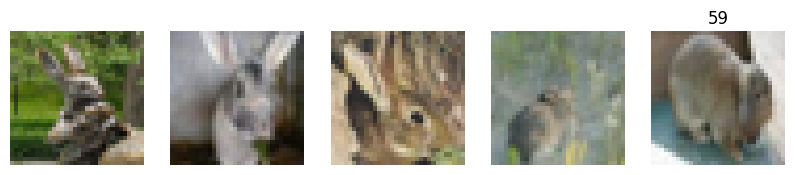

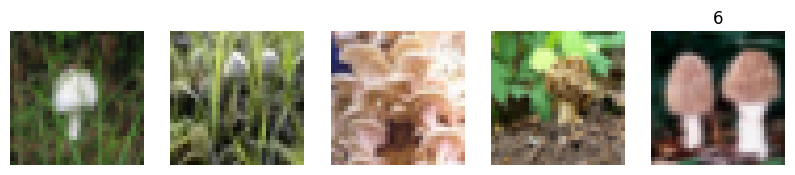

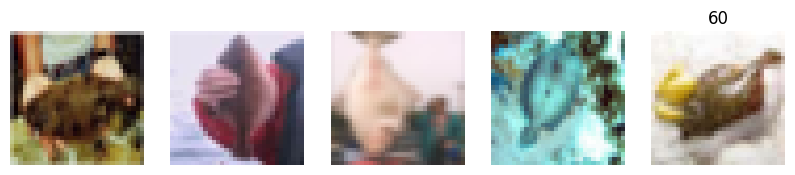

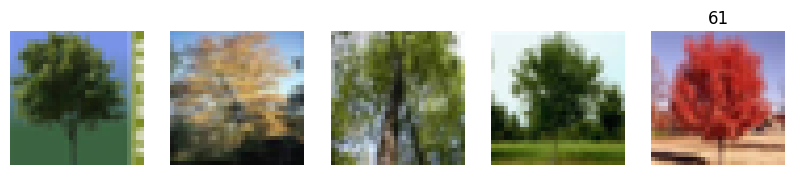

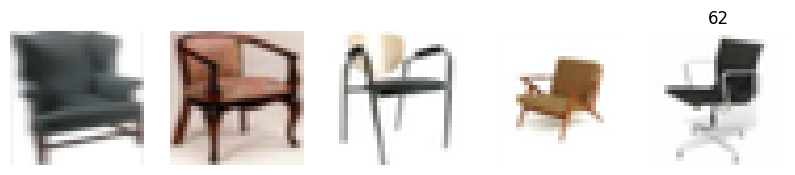

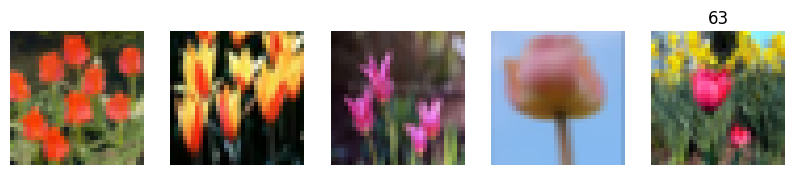

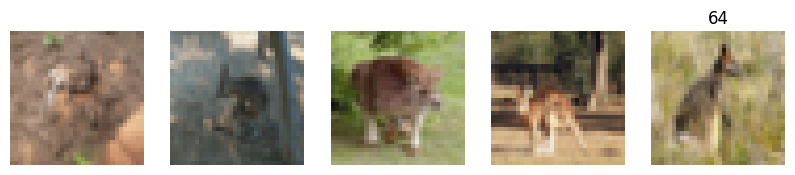

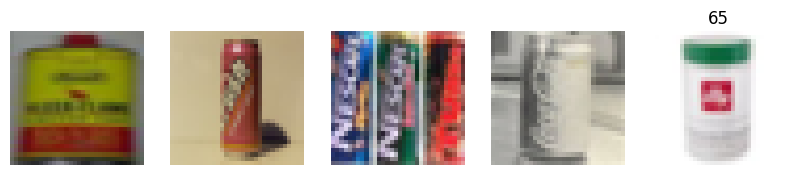

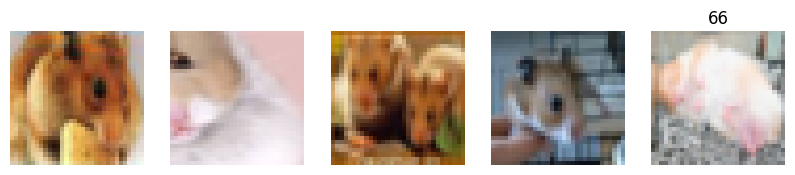

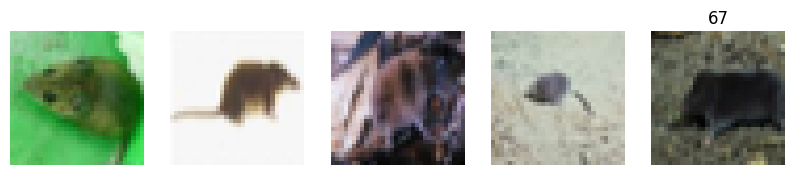

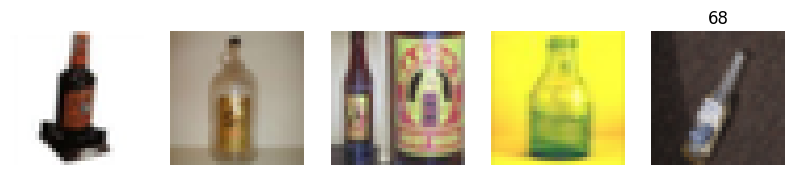

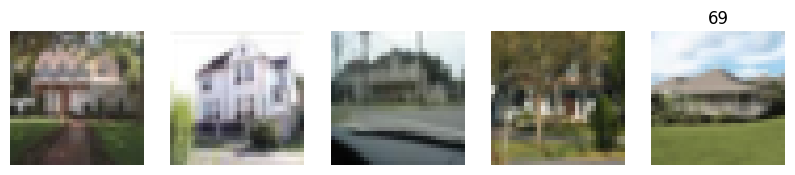

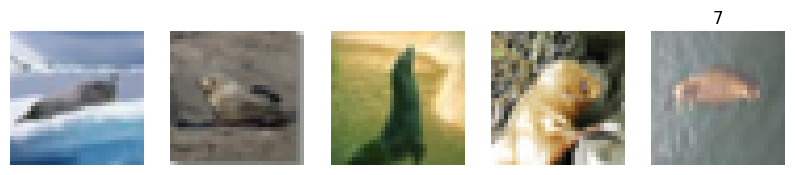

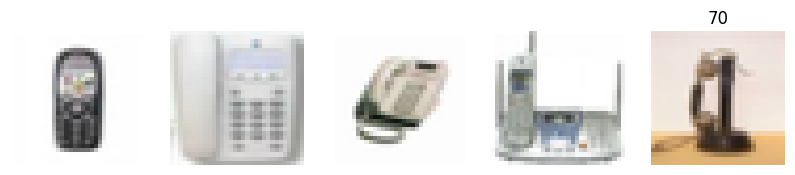

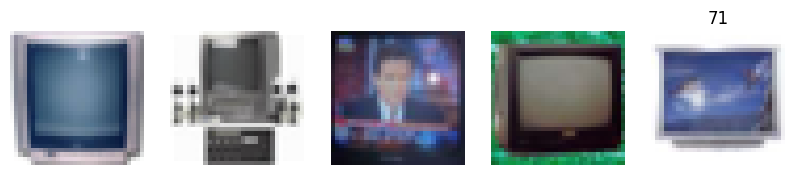

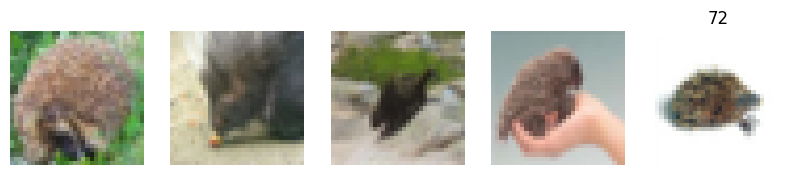

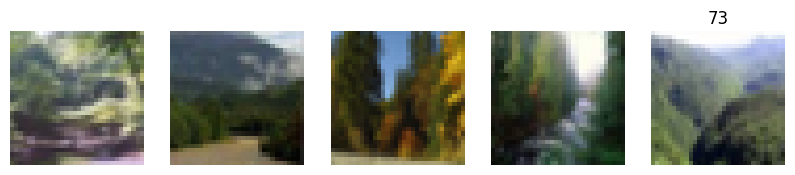

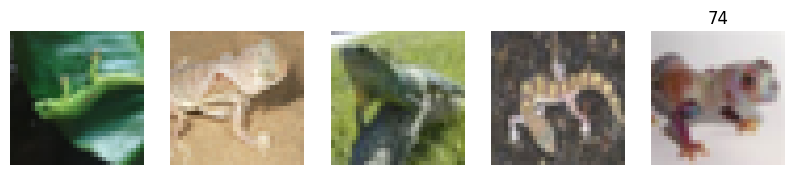

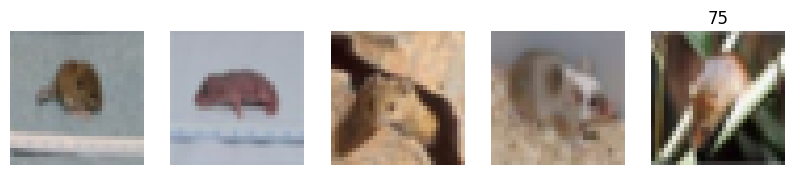

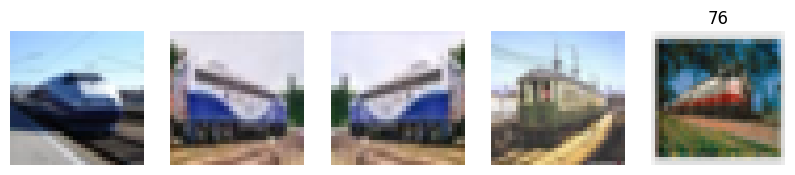

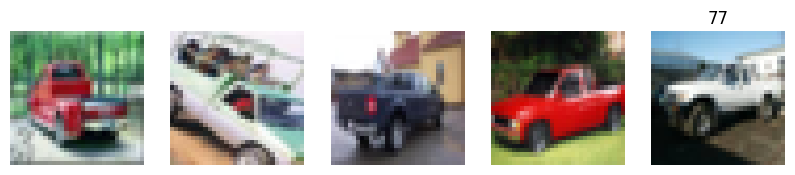

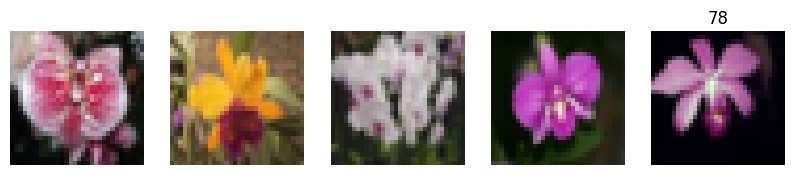

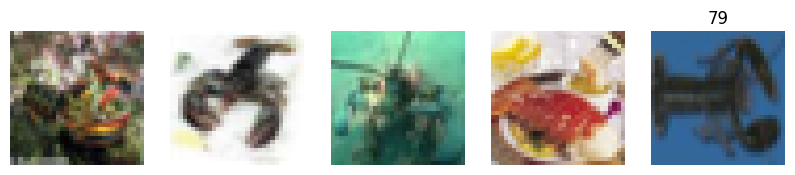

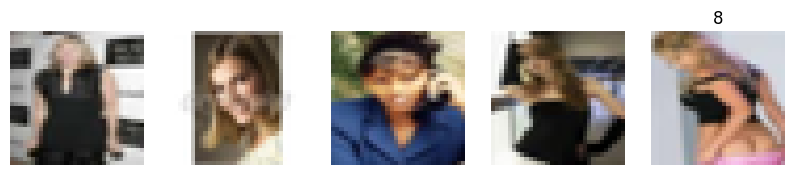

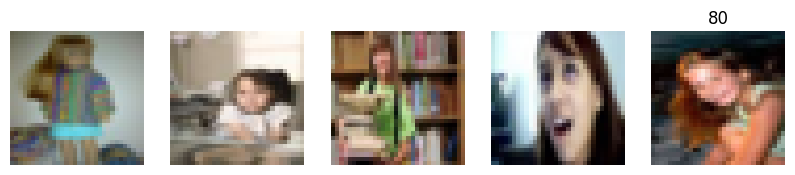

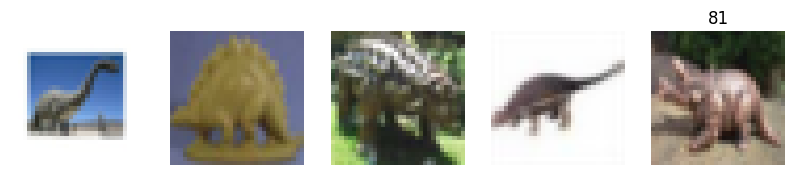

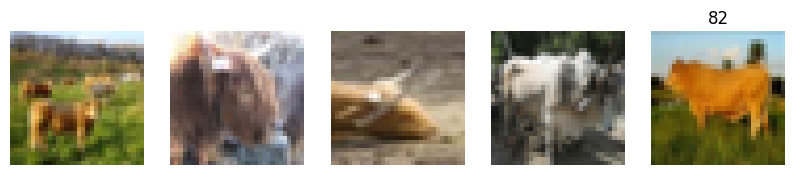

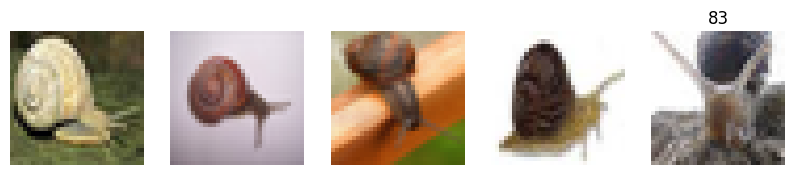

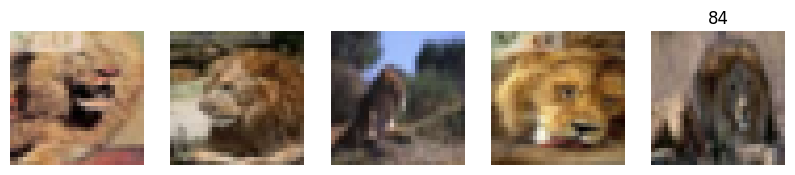

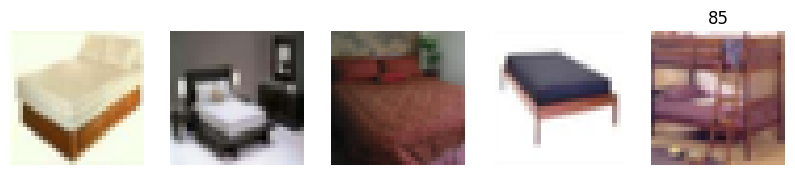

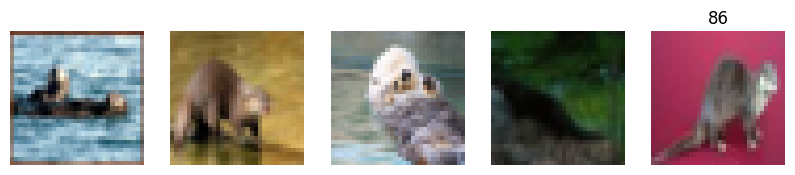

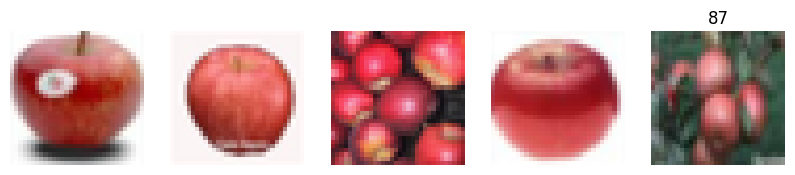

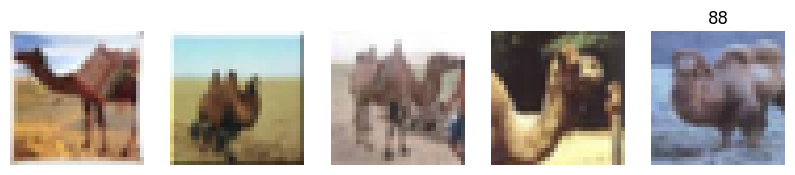

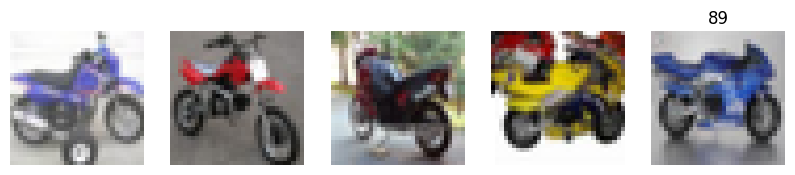

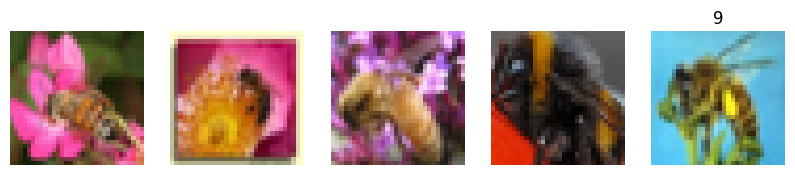

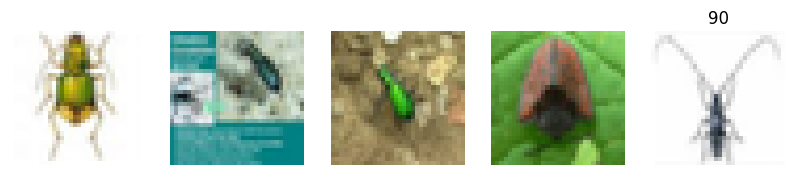

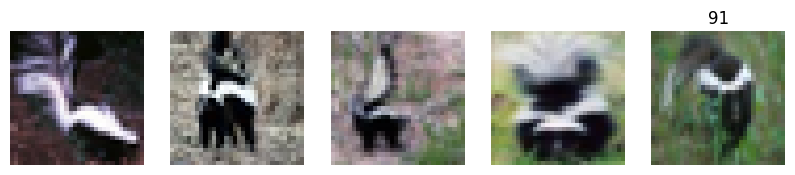

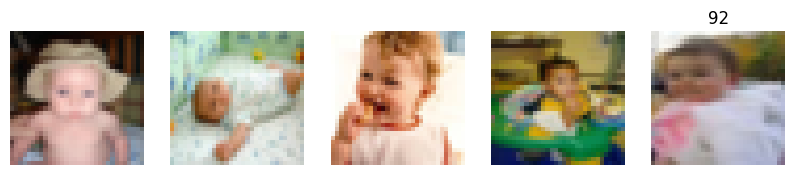

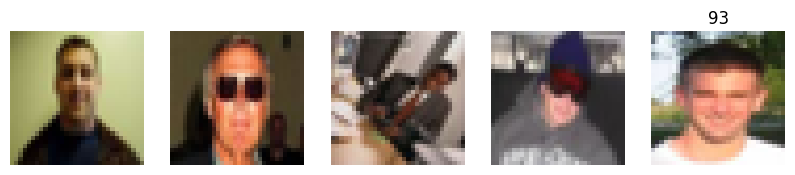

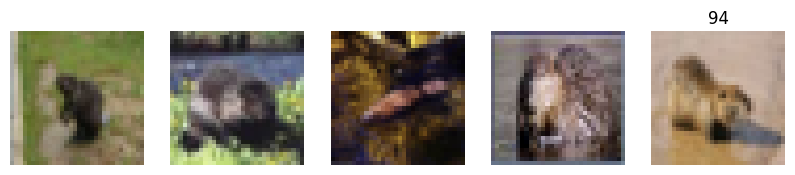

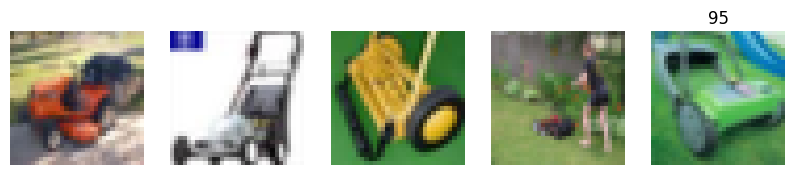

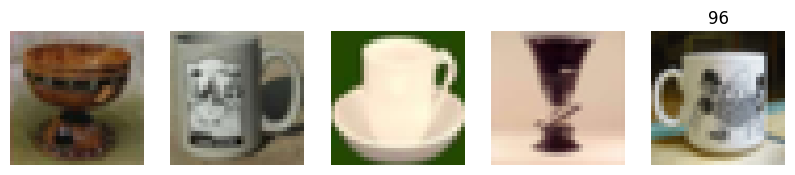

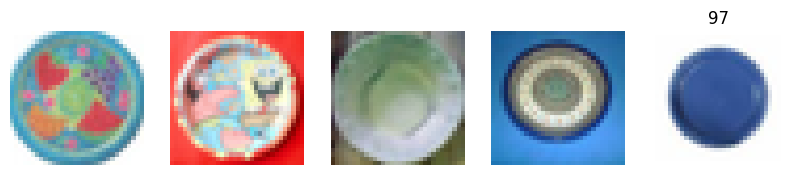

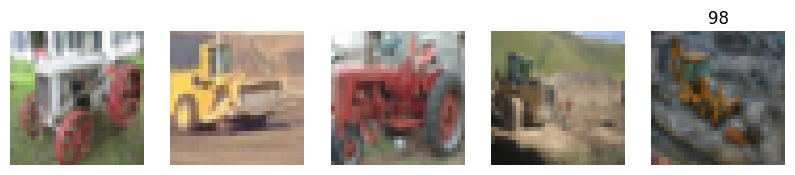

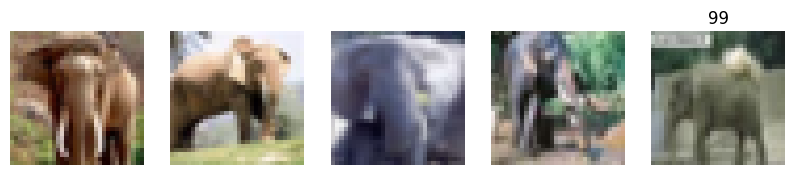

In [13]:
class_images = {}
for img, class_num in train_dataset:
    class_name = train_dataset.classes[class_num]
    if class_name not in class_images:
        class_images[class_name] = []
    class_images[class_name].append(img)
for class_name in train_dataset.classes:
    plt.figure(figsize=(10, 4))
    if class_name in class_images:
        images = class_images[class_name][:5]
    else:
        images = []
    for j, img in enumerate(images):
        plt.subplot(1, 5, j + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.title(class_name)
    plt.show()

0     110
1     109
2     134
3      72
4     117
     ... 
95    101
96     61
97     40
98    112
99     72
Length: 100, dtype: int64

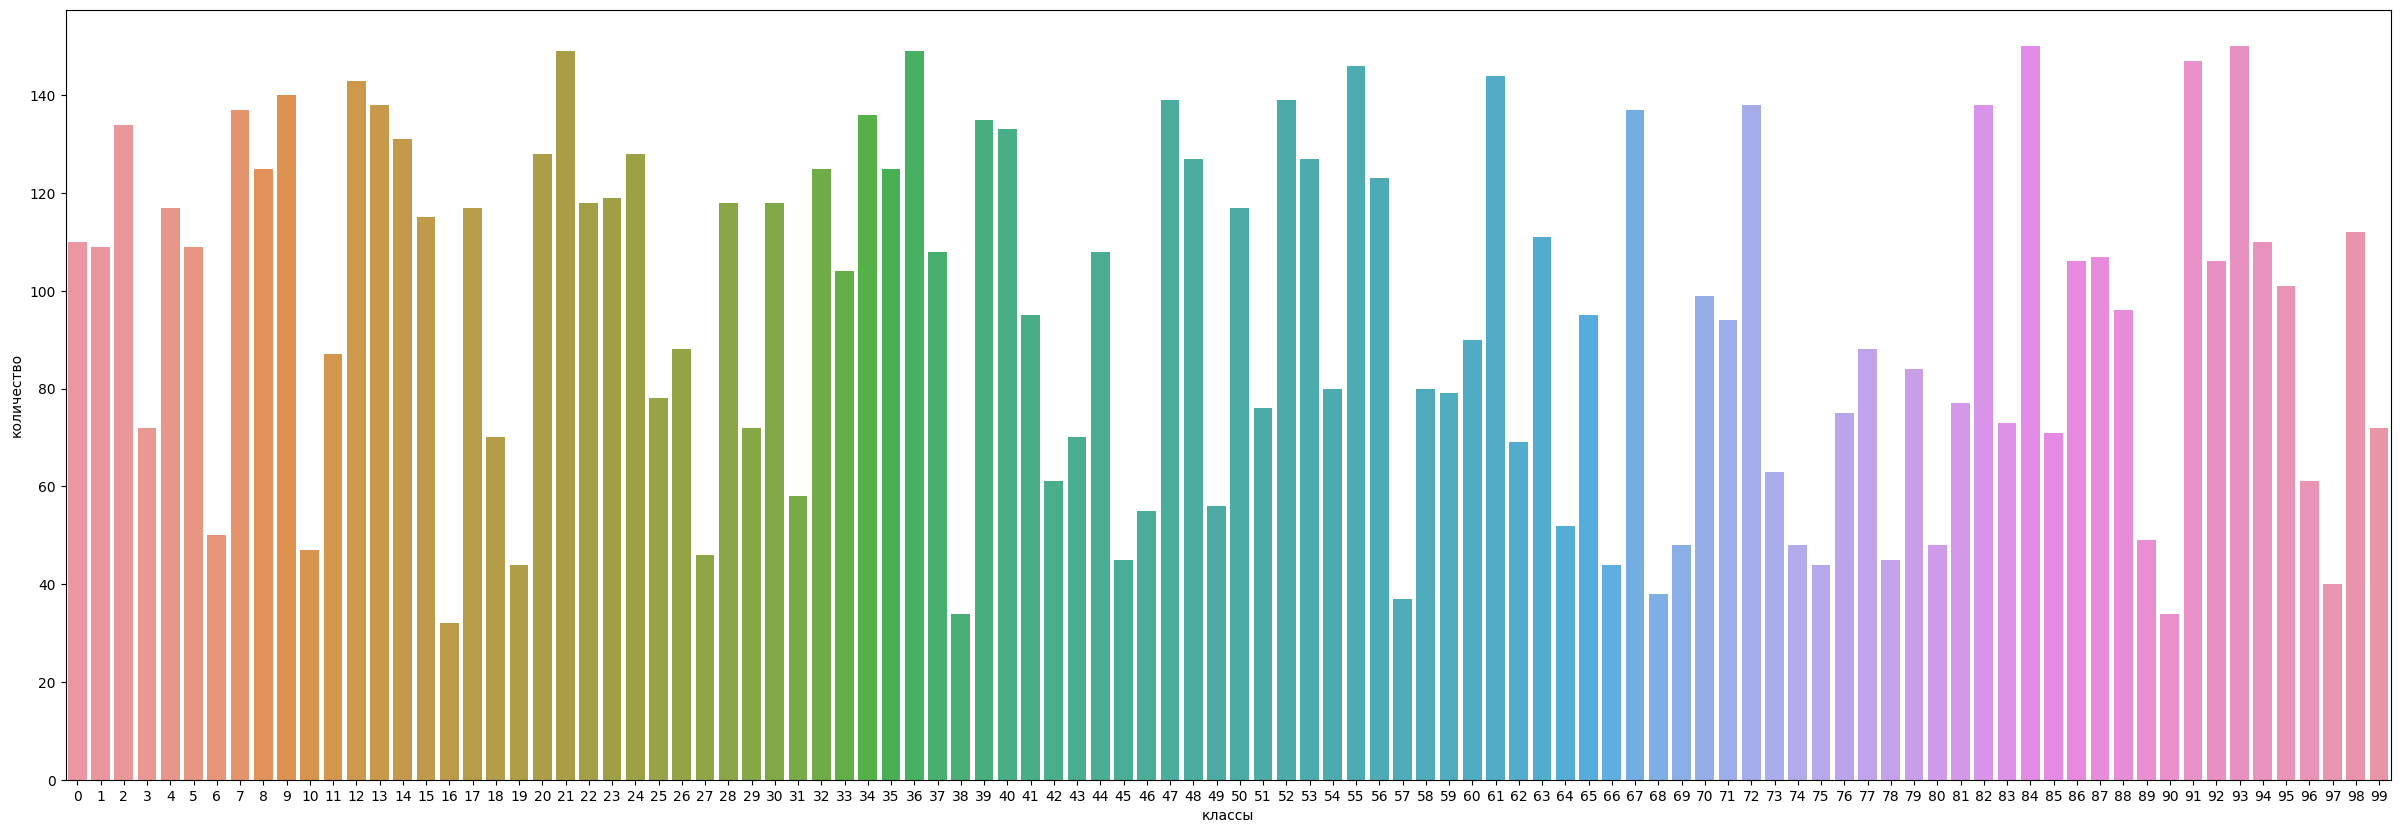

In [14]:

targets_train=pd.Series(train_dataset.targets)
val_sort_count=targets_train.value_counts().sort_index()
display(val_sort_count)

plt.figure(figsize=(30, 10))
sns.barplot(x=val_sort_count.index, y=val_sort_count.values)
plt.xlabel('классы')
plt.ylabel('количество')
plt.show()


Выводы:

1)картинки очень низкого качества , пиксельные, с маленькой размерностью(32 на 32)

2) всего 100 классов

3) также есть дисбаланс классов (количество элементов в каждом классе колеблется примерно от 30 до 140)

4) присутсвует некторая размытость картинки



2 пункт

In [15]:
#навороченные аугментации 
train_trnsf= A.Compose([
    A.MedianBlur(blur_limit=3, p=0.25),
    A.Resize(224, 224, interpolation=cv2.INTER_NEAREST),
    A.MedianBlur(blur_limit=3, p=0.25),
    A.Sharpen(alpha=(0.07, 0.25)),
    A.GridDropout(ratio=0.15,  unit_size_max=1, p=0.3),
    A.HorizontalFlip(p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_trnsf = A.Compose([
    A.Resize(224, 224, interpolation=cv2.INTER_NEAREST),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [16]:
train_trnsf_baz = A.Compose([
    A.Resize(224, 224), 
    A.HorizontalFlip(p=0.3),  
    A.VerticalFlip(p=0.3),   
    A.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    ),
    ToTensorV2()  
])

val_trnsf_baz = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [17]:
class augment(torch.utils.data.Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
            image = cv2.imread(self.file_paths[idx])
            if image is None:
                raise ValueError(f"Не удалось загрузить изображение: {self.file_paths[idx]}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            label = self.labels[idx]
            if self.transform:
                augmented = self.transform(image=image)
                image = augmented['image']

            return image, label

In [18]:
class sfera(datasets.ImageFolder):
    def find_classes(self, directory):
        classes = sorted([d.name for d in os.scandir(directory) if d.is_dir()], key=lambda x: int(x))
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx
    


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
datasfera = sfera(train_direct) 
fil = []
lab = []
for sample in datasfera.samples:
    fil.append(sample[0])
    lab.append(sample[1])

train_fil, val_fil, train_lab, val_lab = train_test_split(fil, lab, test_size=0.2, stratify=lab)

train_dataset = augment(train_fil, train_lab, transform=train_trnsf)
val_dataset = augment(val_fil, val_lab, transform=val_trnsf)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

Using device: cuda


3 пункт

In [20]:
class simp_mod(nn.Module):
    def __init__(self, num_cls):
        super(simp_mod, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, num_cls)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Базовая модель без transfer learning без навороченных аугментаций (только отражение во горизонтали и вертикали)

Using device: cuda
100
Using device: cuda
Эпоха 1/10
трейн лосс: 4.2947
трейн акьюриси: 0.0518
вал лосс: 3.9304
вал акьюриси: 0.0878
лучшая модель: 0.0878
ленинг рейт: [0.001]
*********************************************************
Эпоха 2/10
трейн лосс: 3.7565
трейн акьюриси: 0.1222
вал лосс: 3.6309
вал акьюриси: 0.1399
лучшая модель: 0.1399
ленинг рейт: [0.001]
*********************************************************
Эпоха 3/10
трейн лосс: 3.4668
трейн акьюриси: 0.1652
вал лосс: 3.4638
вал акьюриси: 0.1777
лучшая модель: 0.1777
ленинг рейт: [0.001]
*********************************************************
Эпоха 4/10
трейн лосс: 3.2398
трейн акьюриси: 0.2020
вал лосс: 3.3919
вал акьюриси: 0.1972
лучшая модель: 0.1972
ленинг рейт: [0.001]
*********************************************************
Эпоха 5/10
трейн лосс: 3.0110
трейн акьюриси: 0.2524
вал лосс: 3.3566
вал акьюриси: 0.2050
лучшая модель: 0.2050
ленинг рейт: [0.0001]
*******************************************************

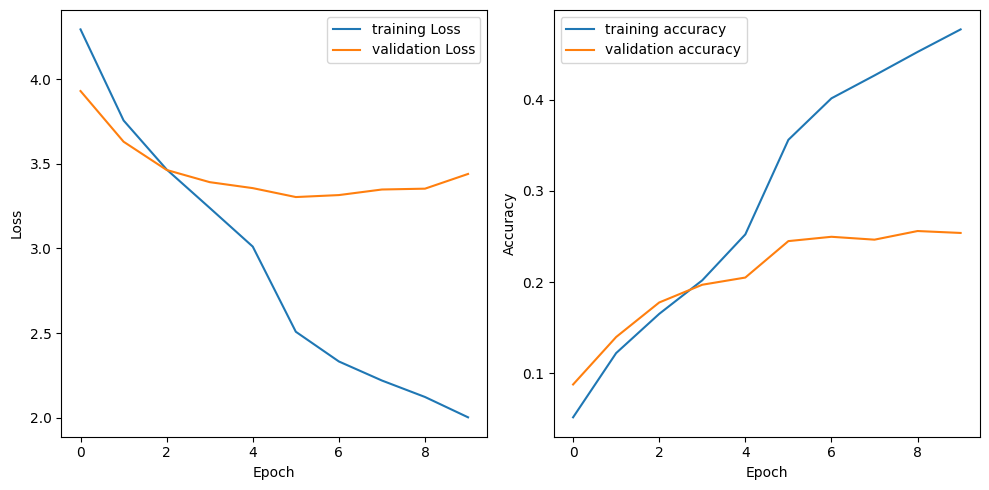


Финальная акьюриси по валидации: 0.2539
Лучшая акьюриси по валидации: 0.2560


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
datasfera = sfera(train_direct) 

fil = []
lab = []
for sample in datasfera.samples:
    fil.append(sample[0])
    lab.append(sample[1])

num_cls = len(datasfera.classes)
print(len(datasfera.classes))

train_fil, val_fil, train_lab, val_lab = train_test_split(fil, lab, test_size=0.2, stratify=lab)

train_dataset = augment(train_fil, train_lab, transform=train_trnsf_baz)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataset = augment(val_fil, val_lab, transform=val_trnsf_baz)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


modelka = simp_mod(num_cls).to(device)

# сюда можно добавить другие лоссы чтобы получить свитч лосей, я просто не смогла найти другие подходящие под эту задачу
func= {
    'CrossEntropyLoss': nn.CrossEntropyLoss(),
}

loss_func = 'CrossEntropyLoss'  
criterion = func[loss_func]
#criterion = nn.CrossEntropyLoss() #weight=weights
optimizer = optim.Adam(modelka.parameters(), lr=0.001) #, weight_decay=1e-4
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_loss_forg = []
val_loss_forg = []
train_acc_forg = []
val_acc_forg = []

improv = 0
best_val_acc = 0.0
tol = 5
for epoch in range(10): 
    modelka.train()
    run_loss = 0.0
    run_acc = 0.0

    for enter, tag in train_loader:
        enter = enter.to(device)
        tag = tag.to(device)

        optimizer.zero_grad()
        outputs = modelka(enter)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, tag)
        loss.backward()
        optimizer.step()

        run_loss += loss.item() * enter.size(0)
        run_acc += torch.sum(preds == tag.data)

    train_loss = run_loss / len(train_loader.dataset)
    train_acc = run_acc.double() / len(train_dataset)

    modelka.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for enter, tag in val_loader:
            enter = enter.to(device)
            tag = tag.to(device)

            outputs = modelka(enter)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, tag)

            val_loss += loss.item() * enter.size(0)
            val_acc += torch.sum(preds == tag.data)

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_acc.double() / len(val_dataset)

    train_loss_forg.append(train_loss)
    val_loss_forg.append(val_loss)
    train_acc_forg.append(train_acc)
    val_acc_forg.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        improv = 0  # Сбрасываем счетчик
        torch.save(modelka.state_dict(), 'best_model.pth')
    else:
        improv += 1  

    if improv >= tol:
        print(f"ранняя остановка сработала на  {epoch + 1} эпохе")
        break

    scheduler.step()

    print(f"Эпоха {epoch + 1}/10")
    print(f"трейн лосс: {train_loss:.4f}")
    print(f"трейн акьюриси: {train_acc:.4f}")
    print(f"вал лосс: {val_loss:.4f}")
    print(f"вал акьюриси: {val_acc:.4f}")
    print(f"лучшая модель: {best_val_acc:.4f}")
    print(f'ленинг рейт: {scheduler.get_last_lr()}')
    print("*********************************************************")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_forg, label='training Loss')
plt.plot(val_loss_forg, label='validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

val_acc_forg_cpu = [tensor.cpu().numpy() for tensor in val_acc_forg]
val_acc_forg_cpu = np.array(val_acc_forg_cpu)
train_acc_forg_cpu = [tensor.cpu().numpy() for tensor in train_acc_forg]
train_acc_forg_cpu = np.array(train_acc_forg_cpu)

plt.subplot(1, 2, 2)
plt.plot(train_acc_forg_cpu, label='training accuracy')
plt.plot(val_acc_forg_cpu, label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

itog_val_acc = val_acc_forg[-1]
print(f"\nФинальная акьюриси по валидации: {itog_val_acc:.4f}")
print(f"Лучшая акьюриси по валидации: {max(val_acc_forg):.4f}")






Базовая модель c transfer learning без навороченных аугментаций (только отражение во горизонтали и вертикали ) с апскейлингом

Using device: cuda
100
Using device: cuda
Эпоха 1/10
трейн лосс: 2.8932
трейн акьюриси: 0.2927
вал лосс: 2.1253
вал акьюриси: 0.4253
лучшая модель: 0.4253
ленинг рейт: [0.001]
*********************************************************
Эпоха 2/10
трейн лосс: 1.8965
трейн акьюриси: 0.4775
вал лосс: 1.8343
вал акьюриси: 0.5116
лучшая модель: 0.5116
ленинг рейт: [0.001]
*********************************************************
Эпоха 3/10
трейн лосс: 1.4915
трейн акьюриси: 0.5733
вал лосс: 1.8032
вал акьюриси: 0.5263
лучшая модель: 0.5263
ленинг рейт: [0.001]
*********************************************************
Эпоха 4/10
трейн лосс: 1.2588
трейн акьюриси: 0.6364
вал лосс: 1.7487
вал акьюриси: 0.5321
лучшая модель: 0.5321
ленинг рейт: [0.001]
*********************************************************
Эпоха 5/10
трейн лосс: 1.0865
трейн акьюриси: 0.6760
вал лосс: 1.7430
вал акьюриси: 0.5531
лучшая модель: 0.5531
ленинг рейт: [0.0001]
*******************************************************

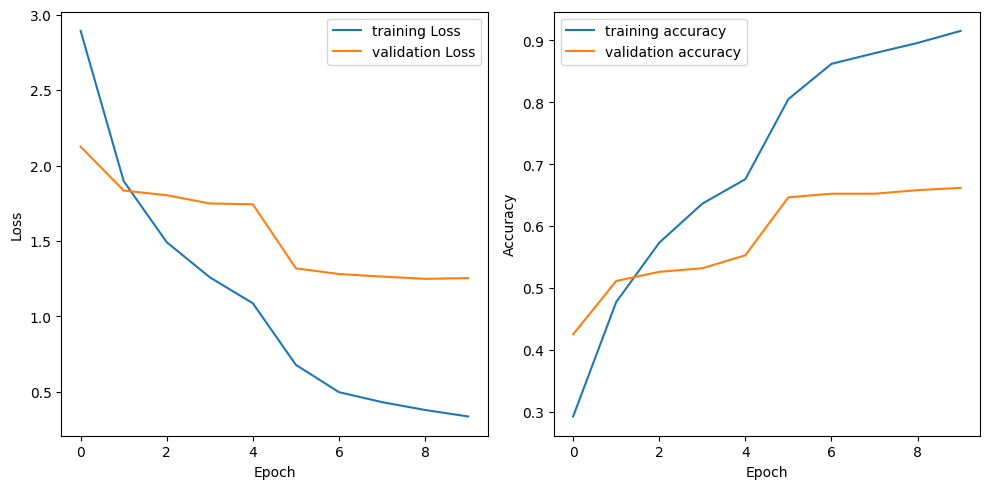


Финальная акьюриси по валидации: 0.6619
Лучшая акьюриси по валидации: 0.6619


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
datasfera = sfera(train_direct) 

fil = []
lab = []
for sample in datasfera.samples:
    fil.append(sample[0])
    lab.append(sample[1])

num_cls = len(datasfera.classes)
print(len(datasfera.classes))

train_fil, val_fil, train_lab, val_lab = train_test_split(fil, lab, test_size=0.2, stratify=lab)

train_dataset = augment(train_fil, train_lab, transform=train_trnsf_baz)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataset = augment(val_fil, val_lab, transform=val_trnsf_baz)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

modelka = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
modelka.classifier[1] = nn.Linear(modelka.classifier[1].in_features, num_cls)  # Изменяем выходной слой
modelka = modelka.to(device)

# сюда можно добавить другие лоссы чтобы получить свитч лосей, я просто не смогла найти другие подходящие под эту задачу
func= {
    'CrossEntropyLoss': nn.CrossEntropyLoss(),
}

loss_func = 'CrossEntropyLoss'  
criterion = func[loss_func]
#criterion = nn.CrossEntropyLoss() #weight=weights
optimizer = optim.Adam(modelka.parameters(), lr=0.001) #, weight_decay=1e-4
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_loss_forg = []
val_loss_forg = []
train_acc_forg = []
val_acc_forg = []

improv = 0
best_val_acc = 0.0
tol = 5
for epoch in range(10): 
    modelka.train()
    run_loss = 0.0
    run_acc = 0.0

    for enter, tag in train_loader:
        enter = enter.to(device)
        tag = tag.to(device)

        optimizer.zero_grad()
        outputs = modelka(enter)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, tag)
        loss.backward()
        optimizer.step()

        run_loss += loss.item() * enter.size(0)
        run_acc += torch.sum(preds == tag.data)

    train_loss = run_loss / len(train_loader.dataset)
    train_acc = run_acc.double() / len(train_dataset)

    modelka.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for enter, tag in val_loader:
            enter = enter.to(device)
            tag = tag.to(device)

            outputs = modelka(enter)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, tag)

            val_loss += loss.item() * enter.size(0)
            val_acc += torch.sum(preds == tag.data)

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_acc.double() / len(val_dataset)

    train_loss_forg.append(train_loss)
    val_loss_forg.append(val_loss)
    train_acc_forg.append(train_acc)
    val_acc_forg.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        improv = 0  # Сбрасываем счетчик
        torch.save(modelka.state_dict(), 'best_model.pth')
    else:
        improv += 1  

    if improv >= tol:
        print(f"ранняя остановка сработала на  {epoch + 1} эпохе")
        break

    scheduler.step()

    print(f"Эпоха {epoch + 1}/10")
    print(f"трейн лосс: {train_loss:.4f}")
    print(f"трейн акьюриси: {train_acc:.4f}")
    print(f"вал лосс: {val_loss:.4f}")
    print(f"вал акьюриси: {val_acc:.4f}")
    print(f"лучшая модель: {best_val_acc:.4f}")
    print(f'ленинг рейт: {scheduler.get_last_lr()}')
    print("*********************************************************")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_forg, label='training Loss')
plt.plot(val_loss_forg, label='validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

val_acc_forg_cpu = [tensor.cpu().numpy() for tensor in val_acc_forg]
val_acc_forg_cpu = np.array(val_acc_forg_cpu)
train_acc_forg_cpu = [tensor.cpu().numpy() for tensor in train_acc_forg]
train_acc_forg_cpu = np.array(train_acc_forg_cpu)

plt.subplot(1, 2, 2)
plt.plot(train_acc_forg_cpu, label='training accuracy')
plt.plot(val_acc_forg_cpu, label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

itog_val_acc = val_acc_forg[-1]
print(f"\nФинальная акьюриси по валидации: {itog_val_acc:.4f}")
print(f"Лучшая акьюриси по валидации: {max(val_acc_forg):.4f}")



In [24]:
#Модель без transfer learning с навороченными аугментациями

Using device: cuda
100
Using device: cuda
Эпоха 1/10
трейн лосс: 4.2719
трейн акьюриси: 0.0647
вал лосс: 3.8326
вал акьюриси: 0.1188
лучшая модель: 0.1188
ленинг рейт: [0.001]
*********************************************************
Эпоха 2/10
трейн лосс: 3.6336
трейн акьюриси: 0.1485
вал лосс: 3.5473
вал акьюриси: 0.1509
лучшая модель: 0.1509
ленинг рейт: [0.001]
*********************************************************
Эпоха 3/10
трейн лосс: 3.2666
трейн акьюриси: 0.2135
вал лосс: 3.3916
вал акьюриси: 0.1940
лучшая модель: 0.1940
ленинг рейт: [0.001]
*********************************************************


IOStream.flush timed out


Эпоха 4/10
трейн лосс: 2.8838
трейн акьюриси: 0.2785
вал лосс: 3.3235
вал акьюриси: 0.2150
лучшая модель: 0.2150
ленинг рейт: [0.001]
*********************************************************
Эпоха 5/10
трейн лосс: 2.3861
трейн акьюриси: 0.3922
вал лосс: 3.4767
вал акьюриси: 0.2245
лучшая модель: 0.2245
ленинг рейт: [0.0001]
*********************************************************
Эпоха 6/10

IOStream.flush timed out



трейн лосс: 1.4865
трейн акьюриси: 0.6145
вал лосс: 3.5367
вал акьюриси: 0.2461
лучшая модель: 0.2461
ленинг рейт: [0.0001]
*********************************************************
Эпоха 7/10
трейн лосс: 1.2573
трейн акьюриси: 0.6701
вал лосс: 3.6673
вал акьюриси: 0.2471
лучшая модель: 0.2471
ленинг рейт: [0.0001]
*********************************************************


IOStream.flush timed out


Эпоха 8/10
трейн лосс: 1.1337
трейн акьюриси: 0.7118
вал лосс: 3.8159
вал акьюриси: 0.2476
лучшая модель: 0.2476
ленинг рейт: [0.0001]
*********************************************************
Эпоха 9/10
трейн лосс: 1.0068
трейн акьюриси: 0.7371
вал лосс: 3.9219
вал акьюриси: 0.2508
лучшая модель: 0.2508
ленинг рейт: [0.0001]
*********************************************************
Эпоха 10/10
трейн лосс: 0.8817
трейн акьюриси: 0.7716
вал лосс: 4.0618
вал акьюриси: 0.2419
лучшая модель: 0.2508
ленинг рейт: [1e-05]
*********************************************************


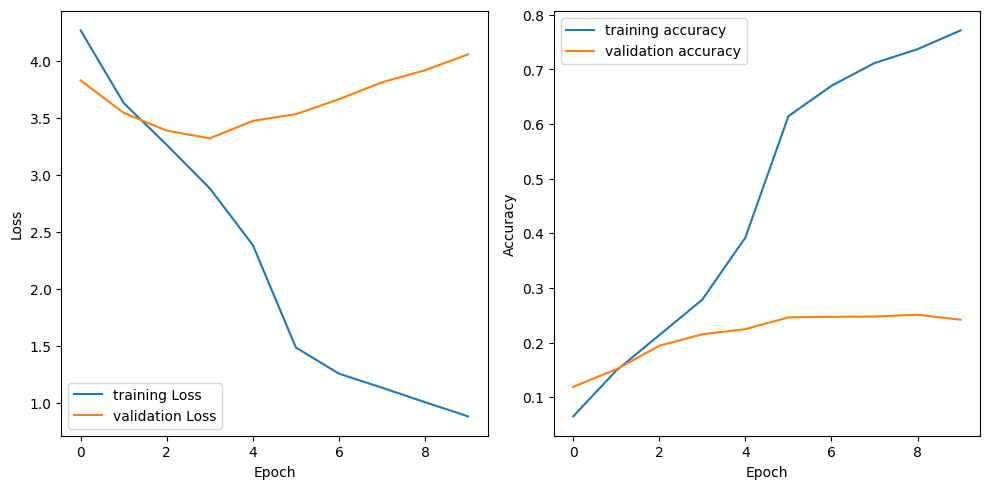


Финальная акьюриси по валидации: 0.2419
Лучшая акьюриси по валидации: 0.2508


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
datasfera = sfera(train_direct) 

fil = []
lab = []
for sample in datasfera.samples:
    fil.append(sample[0])
    lab.append(sample[1])

num_cls = len(datasfera.classes)
print(len(datasfera.classes))

train_fil, val_fil, train_lab, val_lab = train_test_split(fil, lab, test_size=0.2, stratify=lab)

train_dataset = augment(train_fil, train_lab, transform=train_trnsf)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataset = augment(val_fil, val_lab, transform=val_trnsf)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


modelka = simp_mod(num_cls).to(device)

# сюда можно добавить другие лоссы чтобы получить свитч лосей, я просто не смогла найти другие подходящие под эту задачу
func= {
    'CrossEntropyLoss': nn.CrossEntropyLoss(),
}

loss_func = 'CrossEntropyLoss'  
criterion = func[loss_func]
#criterion = nn.CrossEntropyLoss() #weight=weights
optimizer = optim.Adam(modelka.parameters(), lr=0.001) #, weight_decay=1e-4
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_loss_forg = []
val_loss_forg = []
train_acc_forg = []
val_acc_forg = []

improv = 0
best_val_acc = 0.0
tol = 5
for epoch in range(10): 
    modelka.train()
    run_loss = 0.0
    run_acc = 0.0

    for enter, tag in train_loader:
        enter = enter.to(device)
        tag = tag.to(device)

        optimizer.zero_grad()
        outputs = modelka(enter)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, tag)
        loss.backward()
        optimizer.step()

        run_loss += loss.item() * enter.size(0)
        run_acc += torch.sum(preds == tag.data)

    train_loss = run_loss / len(train_loader.dataset)
    train_acc = run_acc.double() / len(train_dataset)

    modelka.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for enter, tag in val_loader:
            enter = enter.to(device)
            tag = tag.to(device)

            outputs = modelka(enter)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, tag)

            val_loss += loss.item() * enter.size(0)
            val_acc += torch.sum(preds == tag.data)

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_acc.double() / len(val_dataset)

    train_loss_forg.append(train_loss)
    val_loss_forg.append(val_loss)
    train_acc_forg.append(train_acc)
    val_acc_forg.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        improv = 0  # Сбрасываем счетчик
        torch.save(modelka.state_dict(), 'best_model.pth')
    else:
        improv += 1  

    if improv >= tol:
        print(f"ранняя остановка сработала на  {epoch + 1} эпохе")
        break

    scheduler.step()

    print(f"Эпоха {epoch + 1}/10")
    print(f"трейн лосс: {train_loss:.4f}")
    print(f"трейн акьюриси: {train_acc:.4f}")
    print(f"вал лосс: {val_loss:.4f}")
    print(f"вал акьюриси: {val_acc:.4f}")
    print(f"лучшая модель: {best_val_acc:.4f}")
    print(f'ленинг рейт: {scheduler.get_last_lr()}')
    print("*********************************************************")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_forg, label='training Loss')
plt.plot(val_loss_forg, label='validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

val_acc_forg_cpu = [tensor.cpu().numpy() for tensor in val_acc_forg]
val_acc_forg_cpu = np.array(val_acc_forg_cpu)
train_acc_forg_cpu = [tensor.cpu().numpy() for tensor in train_acc_forg]
train_acc_forg_cpu = np.array(train_acc_forg_cpu)

plt.subplot(1, 2, 2)
plt.plot(train_acc_forg_cpu, label='training accuracy')
plt.plot(val_acc_forg_cpu, label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

itog_val_acc = val_acc_forg[-1]
print(f"\nФинальная акьюриси по валидации: {itog_val_acc:.4f}")
print(f"Лучшая акьюриси по валидации: {max(val_acc_forg):.4f}")


In [26]:
#Модель с transfer learning с навороченными аугментациями

Using device: cuda
100
Using device: cuda
Эпоха 1/10
трейн лосс: 3.4112
трейн акьюриси: 0.1989
вал лосс: 2.3031
вал акьюриси: 0.3843
лучшая модель: 0.3843
ленинг рейт: [0.001]
*********************************************************
Эпоха 2/10
трейн лосс: 2.1196
трейн акьюриси: 0.4309
вал лосс: 1.8442
вал акьюриси: 0.4900
лучшая модель: 0.4900
ленинг рейт: [0.001]
*********************************************************
Эпоха 3/10
трейн лосс: 1.6517
трейн акьюриси: 0.5368
вал лосс: 1.7900
вал акьюриси: 0.5174
лучшая модель: 0.5174
ленинг рейт: [0.001]
*********************************************************
Эпоха 4/10
трейн лосс: 1.3209
трейн акьюриси: 0.6203
вал лосс: 1.5758
вал акьюриси: 0.5699
лучшая модель: 0.5699
ленинг рейт: [0.001]
*********************************************************
Эпоха 5/10
трейн лосс: 1.0942
трейн акьюриси: 0.6803
вал лосс: 1.6690
вал акьюриси: 0.5605
лучшая модель: 0.5699
ленинг рейт: [0.0001]
*******************************************************

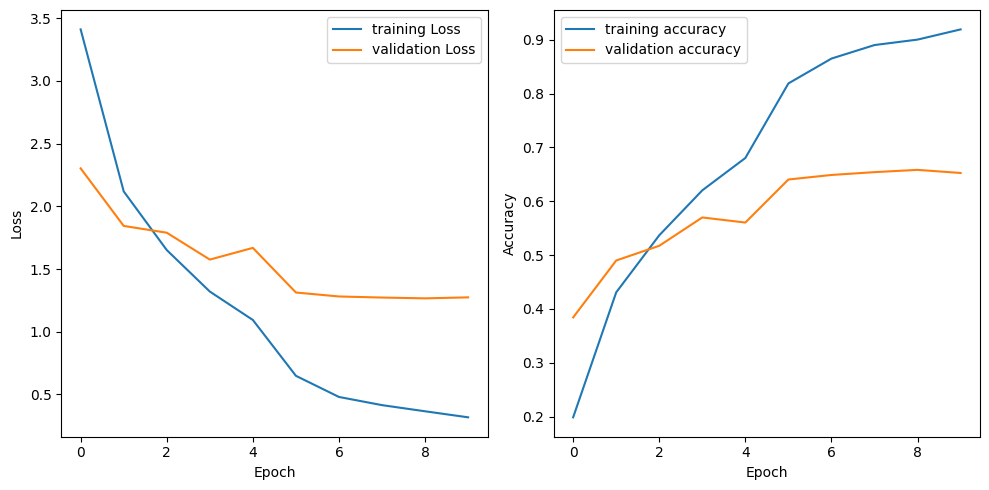


Финальная акьюриси по валидации: 0.6525
Лучшая акьюриси по валидации: 0.6583


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
datasfera = sfera(train_direct) 

fil = []
lab = []
for sample in datasfera.samples:
    fil.append(sample[0])
    lab.append(sample[1])

num_cls = len(datasfera.classes)
print(len(datasfera.classes))

train_fil, val_fil, train_lab, val_lab = train_test_split(fil, lab, test_size=0.2, stratify=lab)

train_dataset = augment(train_fil, train_lab, transform=train_trnsf)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataset = augment(val_fil, val_lab, transform=val_trnsf)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

modelka = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
modelka.classifier[1] = nn.Linear(modelka.classifier[1].in_features, num_cls)  # Изменяем выходной слой
modelka = modelka.to(device)

# сюда можно добавить другие лоссы чтобы получить свитч лосей, я просто не смогла найти другие подходящие под эту задачу
func= {
    'CrossEntropyLoss': nn.CrossEntropyLoss(),
}

loss_func = 'CrossEntropyLoss'  
criterion = func[loss_func]
#criterion = nn.CrossEntropyLoss() #weight=weights
optimizer = optim.Adam(modelka.parameters(), lr=0.001) #, weight_decay=1e-4
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_loss_forg = []
val_loss_forg = []
train_acc_forg = []
val_acc_forg = []

improv = 0
best_val_acc = 0.0
tol = 5
for epoch in range(10): 
    modelka.train()
    run_loss = 0.0
    run_acc = 0.0

    for enter, tag in train_loader:
        enter = enter.to(device)
        tag = tag.to(device)

        optimizer.zero_grad()
        outputs = modelka(enter)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, tag)
        loss.backward()
        optimizer.step()

        run_loss += loss.item() * enter.size(0)
        run_acc += torch.sum(preds == tag.data)

    train_loss = run_loss / len(train_loader.dataset)
    train_acc = run_acc.double() / len(train_dataset)

    modelka.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for enter, tag in val_loader:
            enter = enter.to(device)
            tag = tag.to(device)

            outputs = modelka(enter)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, tag)

            val_loss += loss.item() * enter.size(0)
            val_acc += torch.sum(preds == tag.data)

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_acc.double() / len(val_dataset)

    train_loss_forg.append(train_loss)
    val_loss_forg.append(val_loss)
    train_acc_forg.append(train_acc)
    val_acc_forg.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        improv = 0  # Сбрасываем счетчик
        torch.save(modelka.state_dict(), 'best_model.pth')
    else:
        improv += 1  

    if improv >= tol:
        print(f"ранняя остановка сработала на  {epoch + 1} эпохе")
        break

    scheduler.step()

    print(f"Эпоха {epoch + 1}/10")
    print(f"трейн лосс: {train_loss:.4f}")
    print(f"трейн акьюриси: {train_acc:.4f}")
    print(f"вал лосс: {val_loss:.4f}")
    print(f"вал акьюриси: {val_acc:.4f}")
    print(f"лучшая модель: {best_val_acc:.4f}")
    print(f'ленинг рейт: {scheduler.get_last_lr()}')
    print("*********************************************************")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_forg, label='training Loss')
plt.plot(val_loss_forg, label='validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

val_acc_forg_cpu = [tensor.cpu().numpy() for tensor in val_acc_forg]
val_acc_forg_cpu = np.array(val_acc_forg_cpu)
train_acc_forg_cpu = [tensor.cpu().numpy() for tensor in train_acc_forg]
train_acc_forg_cpu = np.array(train_acc_forg_cpu)

plt.subplot(1, 2, 2)
plt.plot(train_acc_forg_cpu, label='training accuracy')
plt.plot(val_acc_forg_cpu, label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

itog_val_acc = val_acc_forg[-1]
print(f"\nФинальная акьюриси по валидации: {itog_val_acc:.4f}")
print(f"Лучшая акьюриси по валидации: {max(val_acc_forg):.4f}")

4 пункт

In [28]:
import torch.nn.functional as F

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 3. Conditional GAN модели
class Generator(nn.Module):
    def __init__(self, num_classes, latent_dim=100, img_size=224):
        super().__init__()
        self.img_size = img_size
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim + num_classes, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh(),
            nn.AdaptiveAvgPool2d((img_size, img_size))
        )

    def forward(self, noise, labels):
        label_embedding = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([noise, label_embedding], dim=1)
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.label_embedding = nn.Embedding(num_classes, 1)
        
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.AdaptiveAvgPool2d(1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_emb = self.label_embedding(labels).view(-1, 1, 1, 1)
        x = img * (1 + label_emb)
        return self.main(x).view(-1, 1)

# 4. Функции для обучения GAN
def compute_gradient_penalty(netD, real_samples, fake_samples, labels):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = netD(interpolates, labels)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def gener(train_loader, num_classes, num_epochs=50):
    netG = Generator(num_classes).to(device)
    netD = Discriminator(num_classes).to(device)
    
    optimizerD = optim.Adam(netD.parameters(), lr=0.0001, betas=(0.5, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=0.0004, betas=(0.5, 0.999))
    
    for epoch in range(num_epochs):
        for i, (real_imgs, labels) in enumerate(train_loader):
            real_imgs, labels = real_imgs.to(device), labels.to(device)
            batch_size = real_imgs.size(0)
            
            real_labels = torch.full((batch_size, 1), 0.9, device=device)
            fake_labels = torch.full((batch_size, 1), 0.1, device=device)
            
            netD.zero_grad()
            
            output_real = netD(real_imgs + 0.05*torch.randn_like(real_imgs), labels)
            errD_real = F.binary_cross_entropy(output_real, real_labels)
            
            with torch.no_grad():
                noise = torch.randn(batch_size, 100, 1, 1, device=device)
                fake = netG(noise, labels)
            
            output_fake = netD(fake.detach(), labels)
            errD_fake = F.binary_cross_entropy(output_fake, fake_labels)
            
            gradient_penalty = compute_gradient_penalty(netD, real_imgs, fake, labels)
            errD = errD_real + errD_fake + 10.0 * gradient_penalty
            errD.backward()
            optimizerD.step()
            
            if i % 2 == 0:
                netG.zero_grad()
                output = netD(fake, labels)
                errG = F.binary_cross_entropy(output, real_labels)
                errG.backward()
                optimizerG.step()
        
        print(f'Epoch {epoch+1}/{num_epochs}, D loss: {errD.item():.4f}, G loss: {errG.item():.4f}')
    
    return netG

class GAN:
    def __init__(self, generator, target_classes=None, samples_per_class=100):
        self.generator = generator.eval()
        self.target_classes = target_classes
        self.samples_per_class = samples_per_class
        self.generated_samples = {}
        self.device = next(generator.parameters()).device  # Получаем устройство генератора
        
        self._pre_generate_samples()
    
    def _pre_generate_samples(self):
        with torch.no_grad():
            for class_idx in self.target_classes:
                noise = torch.randn(self.samples_per_class, 100, 1, 1, device=self.device)
                labels = torch.full((self.samples_per_class,), class_idx, device=self.device)
                generated = self.generator(noise, labels)
                self.generated_samples[class_idx] = generated.cpu()  # Храним на CPU для экономии памяти
    
    def __call__(self, batch):
        images, labels = batch
        new_images, new_labels = [], []
        
        for class_idx in self.target_classes:
            if class_idx in labels:
                idx = (labels == class_idx)
                num_real = idx.sum().item()
                
                if num_real > 0 and class_idx in self.generated_samples:
                    selected = torch.randint(0, self.samples_per_class, (num_real,))
                    synthetic = self.generated_samples[class_idx][selected].to(self.device)  # Перемещаем на нужное устройство
                    
                    new_images.append(synthetic)
                    new_labels.append(torch.full((num_real,), class_idx, device=self.device))
        
        if new_images:
            images = torch.cat([images] + new_images)
            labels = torch.cat([labels] + new_labels)
        
        return images, labels

    def to(self, device):
        """Метод для совместимости с .to(device)"""
        self.device = device
        return self

def main():
    train_transform = A.Compose([
        A.Resize(224, 224),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    datasfera = sfera(train_direct) 

    fil = []
    lab = []
    for sample in datasfera.samples:
        fil.append(sample[0])
        lab.append(sample[1])

    num_cls = len(datasfera.classes)
    print(len(datasfera.classes))

    train_fil, val_fil, train_lab, val_lab = train_test_split(fil, lab, test_size=0.2, stratify=lab)

    train_dataset = augment(train_fil, train_lab, transform=train_trnsf)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_dataset = augment(val_fil, val_lab, transform=val_trnsf)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"device: {device}")

    print("gan_generator")
    gan_generator = gener(train_loader, num_cls, num_epochs=20)
    
    all_labels = []
    for _, labels in train_loader:
        all_labels.append(labels)
    all_labels = torch.cat(all_labels)
    class_counts = Counter(all_labels.cpu().numpy())
    target_classes = sorted(class_counts, key=class_counts.get)[:len(class_counts)//4]
    
    gan_augmenter = GAN(
        generator=gan_generator,
        target_classes=target_classes,
        samples_per_class=200
    ).to(device)  

    def augm_col(batch):
        batch = torch.utils.data.default_collate(batch)
        batch = (batch[0].to(device), batch[1].to(device))
        return gan_augmenter(batch)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=32, 
        shuffle=True, 
        num_workers=0,
        collate_fn=augm_col
    )
    modelka = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
    modelka.classifier[1] = nn.Linear(modelka.classifier[1].in_features, num_cls)  
    modelka = modelka.to(device)

    # сюда можно добавить другие лоссы чтобы получить свитч лосей, я просто не смогла найти другие подходящие под эту задачу
    func= {
        'CrossEntropyLoss': nn.CrossEntropyLoss(),
    }

    loss_func = 'CrossEntropyLoss'  
    criterion = func[loss_func]
    optimizer = optim.Adam(modelka.parameters(), lr=0.001) #, weight_decay=1e-4
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    train_loss_forg = []
    val_loss_forg = []
    train_acc_forg = []
    val_acc_forg = []

    improv = 0
    best_val_acc = 0.0
    tol = 5
    for epoch in range(10): 
        modelka.train()
        run_loss = 0.0
        run_acc = 0.0

        for enter, tag in train_loader:
            enter = enter.to(device)
            tag = tag.to(device)

            optimizer.zero_grad()
            outputs = modelka(enter)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, tag)
            loss.backward()
            optimizer.step()

            run_loss += loss.item() * enter.size(0)
            run_acc += torch.sum(preds == tag.data)

        train_loss = run_loss / len(train_loader.dataset)
        train_acc = run_acc.double() / len(train_dataset)

        modelka.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            for enter, tag in val_loader:
                enter = enter.to(device)
                tag = tag.to(device)

                outputs = modelka(enter)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, tag)

                val_loss += loss.item() * enter.size(0)
                val_acc += torch.sum(preds == tag.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_acc.double() / len(val_dataset)

        train_loss_forg.append(train_loss)
        val_loss_forg.append(val_loss)
        train_acc_forg.append(train_acc)
        val_acc_forg.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            improv = 0  # Сбрасываем счетчик
            torch.save(modelka.state_dict(), 'best_model.pth')
        else:
            improv += 1  

        if improv >= tol:
            print(f"ранняя остановка сработала на  {epoch + 1} эпохе")
            break

        scheduler.step()
        print(f"Эпоха {epoch + 1}/10")
        print(f"трейн лосс: {train_loss:.4f}")
        print(f"трейн акьюриси: {train_acc:.4f}")
        print(f"вал лосс: {val_loss:.4f}")
        print(f"вал акьюриси: {val_acc:.4f}")
        print(f"лучшая модель: {best_val_acc:.4f}")
        print(f'ленинг рейт: {scheduler.get_last_lr()}')
        print("*********************************************************")

   

if __name__ == '__main__':
    main()

Using device: cuda
Using device: cuda
100
device: cuda
gan_generator
Epoch 1/20, D loss: 5.2956, G loss: 2.2306
Epoch 2/20, D loss: 5.1992, G loss: 2.0065
Epoch 3/20, D loss: 3.6031, G loss: 1.7548
Epoch 4/20, D loss: 2.2297, G loss: 2.0021
Epoch 5/20, D loss: 2.4402, G loss: 1.7426
Epoch 6/20, D loss: 2.0733, G loss: 2.1888
Epoch 7/20, D loss: 2.5761, G loss: 1.9614
Epoch 8/20, D loss: 1.8700, G loss: 2.4412
Epoch 9/20, D loss: 2.3909, G loss: 2.0667
Epoch 10/20, D loss: 1.9380, G loss: 1.8862
Epoch 11/20, D loss: 1.4935, G loss: 1.9709
Epoch 12/20, D loss: 1.9953, G loss: 2.0042
Epoch 13/20, D loss: 1.7940, G loss: 2.0497
Epoch 14/20, D loss: 2.5074, G loss: 2.3951
Epoch 15/20, D loss: 1.5420, G loss: 2.0557
Epoch 16/20, D loss: 1.4272, G loss: 2.0781
Epoch 17/20, D loss: 1.4560, G loss: 1.5893
Epoch 18/20, D loss: 1.1161, G loss: 1.7666
Epoch 19/20, D loss: 1.4712, G loss: 2.3601
Epoch 20/20, D loss: 1.4624, G loss: 2.2367
Эпоха 1/10
трейн лосс: 3.7053
трейн акьюриси: 0.2326
вал лос

In [38]:
#лучшая модель ( которая получида скор на каггле)

In [39]:
#лучшая модель ( которая получида скор на каггле)

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from IPython.display import display
import zipfile
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torchvision.models import densenet121 
from torchvision.models import densenet121, DenseNet121_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torchvision.models import mobilenet_v2
from torchvision.models import MobileNet_V2_Weights
from torch.optim.lr_scheduler import LambdaLR
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
import torch.nn.functional as F


In [41]:
train_trnsf= A.Compose([
    A.MedianBlur(blur_limit=3, p=0.25),
    A.Resize(224, 224, interpolation=cv2.INTER_NEAREST),
    A.MedianBlur(blur_limit=3, p=0.25),
    A.Sharpen(alpha=(0.07, 0.25)),
    A.GridDropout(ratio=0.15,  unit_size_max=1, p=0.3),
    A.HorizontalFlip(p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_trnsf = A.Compose([
    A.Resize(224, 224, interpolation=cv2.INTER_NEAREST),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])
class augment(torch.utils.data.Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
            image = cv2.imread(self.file_paths[idx])
            if image is None:
                raise ValueError(f"Не удалось загрузить изображение: {self.file_paths[idx]}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            label = self.labels[idx]
            if self.transform:
                augmented = self.transform(image=image)
                image = augmented['image']

            return image, label
class sfera(datasets.ImageFolder):
    def find_classes(self, directory):
        classes = sorted([d.name for d in os.scandir(directory) if d.is_dir()], key=lambda x: int(x))
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

In [ ]:
data="data (1).zip"
with zipfile.ZipFile(data, 'r') as zipf:
    zipf.extractall("dataset")

Using device: cuda
100
Using device: cuda
Эпоха 1/20
трейн лосс: 3.3190
трейн акьюриси: 0.2220
вал лосс: 2.4411
вал акьюриси: 0.3738
лучшая модель: 0.3738
ленинг рейт: [0.001]
*********************************************************
Эпоха 2/20
трейн лосс: 2.0784
трейн акьюриси: 0.4398
вал лосс: 1.9546
вал акьюриси: 0.4863
лучшая модель: 0.4863
ленинг рейт: [0.001]
*********************************************************
Эпоха 3/20
трейн лосс: 1.6213
трейн акьюриси: 0.5452
вал лосс: 1.8903
вал акьюриси: 0.5047
лучшая модель: 0.5047
ленинг рейт: [0.001]
*********************************************************
Эпоха 4/20
трейн лосс: 1.3238
трейн акьюриси: 0.6225
вал лосс: 1.6657
вал акьюриси: 0.5547
лучшая модель: 0.5547
ленинг рейт: [0.001]
*********************************************************
Эпоха 5/20
трейн лосс: 1.0837
трейн акьюриси: 0.6795
вал лосс: 1.7782
вал акьюриси: 0.5358
лучшая модель: 0.5547
ленинг рейт: [0.0001]
*******************************************************

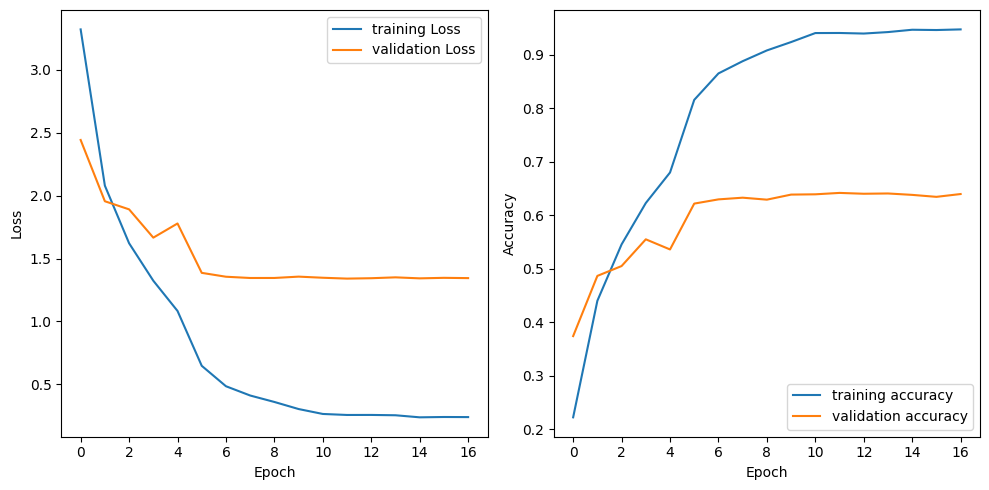


Финальная акьюриси по валидации: 0.6393
Лучшая акьюриси по валидации: 0.6414


In [42]:
train_direct="dataset/train"
test_direct="dataset/test"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
datasfera = sfera(train_direct) 

fil = []
lab = []
for sample in datasfera.samples:
    fil.append(sample[0])
    lab.append(sample[1])

num_cls = len(datasfera.classes)
print(len(datasfera.classes))

train_fil, val_fil, train_lab, val_lab = train_test_split(fil, lab, test_size=0.2, stratify=lab)

train_dataset = augment(train_fil, train_lab, transform=train_trnsf)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataset = augment(val_fil, val_lab, transform=val_trnsf)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

modelka = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
modelka.classifier[1] = nn.Linear(modelka.classifier[1].in_features, num_cls)  
modelka = modelka.to(device)

# сюда можно добавить другие лоссы чтобы получить свитч лосей, я просто не смогла найти другие подходящие под эту задачу
func= {
    'CrossEntropyLoss': nn.CrossEntropyLoss(),
}

loss_func = 'CrossEntropyLoss'  
criterion = func[loss_func]
optimizer = optim.Adam(modelka.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_loss_forg = []
val_loss_forg = []
train_acc_forg = []
val_acc_forg = []

improv = 0
best_val_acc = 0.0
tol = 5
for epoch in range(20): 
    modelka.train()
    run_loss = 0.0
    run_acc = 0.0

    for enter, tag in train_loader:
        enter = enter.to(device)
        tag = tag.to(device)

        optimizer.zero_grad()
        outputs = modelka(enter)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, tag)
        loss.backward()
        optimizer.step()

        run_loss += loss.item() * enter.size(0)
        run_acc += torch.sum(preds == tag.data)

    train_loss = run_loss / len(train_loader.dataset)
    train_acc = run_acc.double() / len(train_dataset)

    modelka.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for enter, tag in val_loader:
            enter = enter.to(device)
            tag = tag.to(device)

            outputs = modelka(enter)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, tag)

            val_loss += loss.item() * enter.size(0)
            val_acc += torch.sum(preds == tag.data)

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_acc.double() / len(val_dataset)

    train_loss_forg.append(train_loss)
    val_loss_forg.append(val_loss)
    train_acc_forg.append(train_acc)
    val_acc_forg.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        improv = 0  # Сбрасываем счетчик
        torch.save(modelka.state_dict(), 'best_model.pth')
    else:
        improv += 1  

    if improv >= tol:
        print(f"ранняя остановка сработала на  {epoch + 1} эпохе")
        break

    scheduler.step()

    print(f"Эпоха {epoch + 1}/20")
    print(f"трейн лосс: {train_loss:.4f}")
    print(f"трейн акьюриси: {train_acc:.4f}")
    print(f"вал лосс: {val_loss:.4f}")
    print(f"вал акьюриси: {val_acc:.4f}")
    print(f"лучшая модель: {best_val_acc:.4f}")
    print(f'ленинг рейт: {scheduler.get_last_lr()}')
    print("*********************************************************")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_forg, label='training Loss')
plt.plot(val_loss_forg, label='validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

val_acc_forg_cpu = [tensor.cpu().numpy() for tensor in val_acc_forg]
val_acc_forg_cpu = np.array(val_acc_forg_cpu)
train_acc_forg_cpu = [tensor.cpu().numpy() for tensor in train_acc_forg]
train_acc_forg_cpu = np.array(train_acc_forg_cpu)

plt.subplot(1, 2, 2)
plt.plot(train_acc_forg_cpu, label='training accuracy')
plt.plot(val_acc_forg_cpu, label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

itog_val_acc = val_acc_forg[-1]
print(f"\nФинальная акьюриси по валидации: {itog_val_acc:.4f}")
print(f"Лучшая акьюриси по валидации: {max(val_acc_forg):.4f}")

In [43]:
class LoadingTest(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [f for f in sorted(os.listdir(root_dir)) 
                      if os.path.isfile(os.path.join(root_dir, f)) 
                      and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        try:
            image = cv2.imread(img_name)
            if image is None:
                raise ValueError(f"Не удалось загрузить: {img_name}")
                
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            if self.transform:
                augmented = self.transform(image=image)
                image = augmented['image']
                
            return image 
            
        except Exception as e:
            print(f"Ошибка обработки {img_name}: {str(e)}")
            dummy = np.zeros((32, 32, 3), dtype=np.uint8)  # Размер как в train
            if self.transform:
                dummy = self.transform(image=dummy)['image']
            return dummy

test_transform = A.Compose([
    A.Resize(224, 224 , interpolation=cv2.INTER_NEAREST),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

modelka.eval()

test_dataset = LoadingTest(root_dir="dataset/test", transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

test_predictions = []
image_ids = []

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(device)
        outputs = modelka(inputs)
        _, preds = torch.max(outputs, 1)
        test_predictions.extend(preds.cpu().numpy())
        image_ids.extend([test_dataset.images[i] for i in range(len(preds))])
    
for i in range(10):
     print(f'изображение: {test_dataset.images[i]}, pred: {test_predictions[i]}')
        
image_ids = [img_name.split('.')[0] for img_name in test_dataset.images]
submission_df = pd.DataFrame({
    'id': image_ids,
    'target': test_predictions
})

submission_df['id_num'] = pd.to_numeric(submission_df['id'], errors='coerce')
submission_df = submission_df.sort_values('id_num').drop('id_num', axis=1)
submission_df = submission_df.reset_index(drop=True)

submission_file = 'sample_submission.csv'
submission_df.to_csv(submission_file, index=False)
print(submission_df)

изображение: 0.png, pred: 71
изображение: 1.png, pred: 62
изображение: 10.png, pred: 18
изображение: 100.png, pred: 19
изображение: 1000.png, pred: 40
изображение: 1001.png, pred: 71
изображение: 1002.png, pred: 91
изображение: 1003.png, pred: 98
изображение: 1004.png, pred: 95
изображение: 1005.png, pred: 91
        id  target
0        0      71
1        1      62
2        2      18
3        3      41
4        4      66
...    ...     ...
3873  3873       0
3874  3874      42
3875  3875      95
3876  3876      91
3877  3877      75

[3878 rows x 2 columns]
